In [2]:
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 获取指定时间段的股票数据，并计算每日收盘价的变化率。
def prepare_data(symbol, start_date, end_date):
    # 获取指定时间段的股票数据
    data = ak.stock_zh_index_daily_em(symbol=symbol, start_date=start_date, end_date=end_date)
    # 计算每日收盘价的变化率，并去除NaN值
    data['pct_change'] = data['close'].pct_change().dropna() * 100
    
    # 绘制收盘价历史图像
    plt.figure(figsize=(14, 7))
    plt.plot(data['close'], label='Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Close Price History')
    plt.show()
    
    return data

# 根据给定的状态数和范围将数据离散化。
def discretize_data(data, N, lower_bound=-5, upper_bound=5):
    # 生成状态边界
    state_bounds = np.linspace(lower_bound, upper_bound, N + 1)
    # 将数据离散化为状态
    states = np.digitize(data['pct_change'], state_bounds) - 1
    # 确保状态值在合法范围内
    states = np.clip(states, 0, N-1)

    # 打印每一个区间对应的变化状态
    for i in range(N):
        print(f"state {i}: {state_bounds[i]:.2f}% ~ {state_bounds[i+1]:.2f}%")

    # 可视化价格变化率
    plt.figure(figsize=(14, 7))
    plt.plot(data['pct_change'])
    plt.title('Daily Price Change Rate')
    plt.xlabel('Day')
    plt.ylabel('Change Rate (%)')
    plt.show()

    return states, state_bounds



# 计算状态转移矩阵并进行归一化。
def compute_transition_matrix(states, N):
    # 初始化转移矩阵
    transition_matrix = np.zeros((N, N))
    # 计算转移次数
    for (i, j) in zip(states[:-1], states[1:]):
        transition_matrix[i, j] += 1
    # 对转移矩阵进行归一化
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    return transition_matrix

# 可视化转移矩阵。
def visualize_transition_matrix(transition_matrix, title='Transition Matrix Heatmap'):
    # 绘制转移矩阵的热图
    plt.figure(figsize=(10, 8))
    plt.imshow(transition_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('State t+1')
    plt.ylabel('State t')
    plt.show()

# 检查转移矩阵是否收敛。
def check_convergence(matrix, iterations=100):
    current_matrix = matrix.copy()
    # 进行多次矩阵乘法，检查是否收敛
    for i in range(iterations):
        next_matrix = np.dot(current_matrix, matrix)
        if np.allclose(next_matrix, current_matrix, atol=1e-2):
            return True, i + 1
        current_matrix = next_matrix
    return False, iterations

# 可视化转移矩阵的收敛过程
def visualize_convergence(matrix, iterations=10):
    current_matrix = matrix.copy()
    # 进行多次矩阵乘法，并逐次可视化
    for i in range(iterations):
        next_matrix = np.dot(current_matrix, matrix)
        visualize_transition_matrix(next_matrix, title=f'Transition Matrix after {i + 1} Iterations')
        current_matrix = next_matrix

# 绘制状态分布的直方图。
def plot_state_distribution(states, N):
    # 计算每个状态的频数
    state_counts = np.bincount(states, minlength=N)
    # 绘制状态分布的直方图
    plt.figure(figsize=(14, 7))
    plt.bar(range(N), state_counts)
    plt.xlabel('State')
    plt.ylabel('Frequency')
    plt.title('State Frequency Distribution')
    plt.show()

# 整合上述所有步骤并执行主函数。
def main(symbol, train_start_date, train_end_date, test_start_date, test_end_date, N=10, lower_bound=-5, upper_bound=5):
    # 准备训练数据
    train_data = prepare_data(symbol, train_start_date, train_end_date)
    
    # 离散化训练数据
    train_states, state_bounds = discretize_data(train_data, N, lower_bound, upper_bound)
    
    # 绘制训练数据的状态分布
    plot_state_distribution(train_states, N)

    # 计算并可视化训练数据的转移矩阵
    train_transition_matrix = compute_transition_matrix(train_states, N)
    visualize_transition_matrix(train_transition_matrix)
    
    # 检查转移矩阵的收敛性
    is_converged, steps = check_convergence(train_transition_matrix)
    print(f"转移矩阵是否收敛: {is_converged}, 收敛所需步数: {steps}")
    
    # 可视化转移矩阵的收敛性
    visualize_convergence(train_transition_matrix)
    
    # 准备测试数据
    test_data = prepare_data(symbol, test_start_date, test_end_date)
    
    # 离散化测试数据
    test_states, _ = discretize_data(test_data, N, lower_bound, upper_bound)
    
    # 计算并可视化测试数据的转移矩阵
    test_transition_matrix = compute_transition_matrix(test_states, N)
    visualize_transition_matrix(test_transition_matrix, title='Test Transition Matrix Heatmap')
    
    # 绘制测试数据的状态分布
    plot_state_distribution(test_states, N)


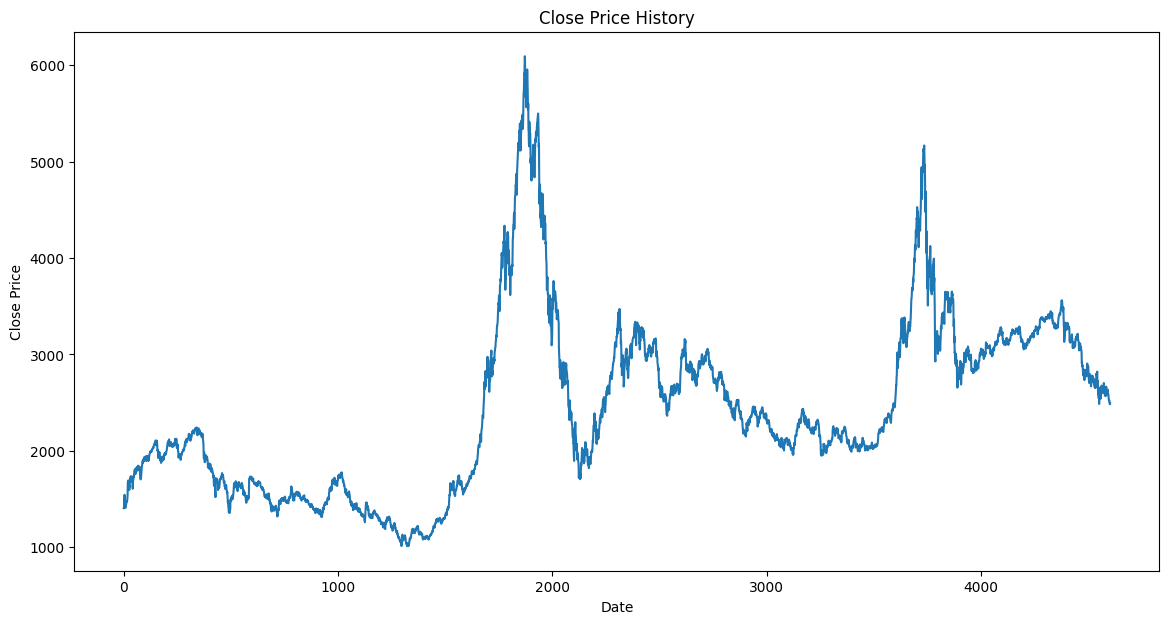

state 0: -5.00% ~ -4.00%
state 1: -4.00% ~ -3.00%
state 2: -3.00% ~ -2.00%
state 3: -2.00% ~ -1.00%
state 4: -1.00% ~ 0.00%
state 5: 0.00% ~ 1.00%
state 6: 1.00% ~ 2.00%
state 7: 2.00% ~ 3.00%
state 8: 3.00% ~ 4.00%
state 9: 4.00% ~ 5.00%


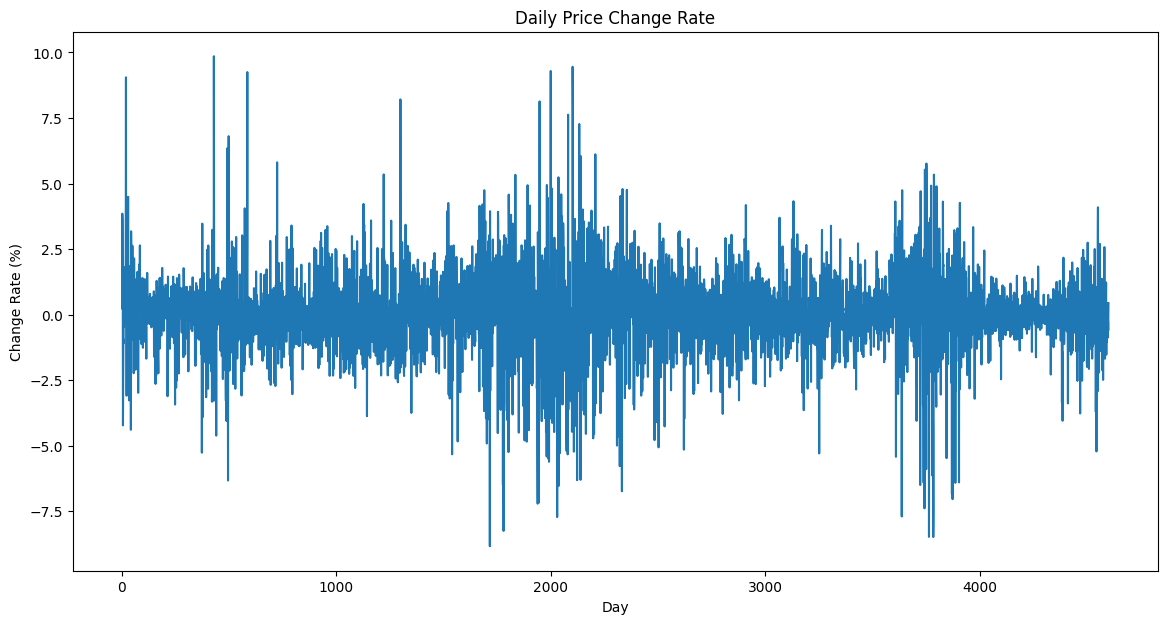

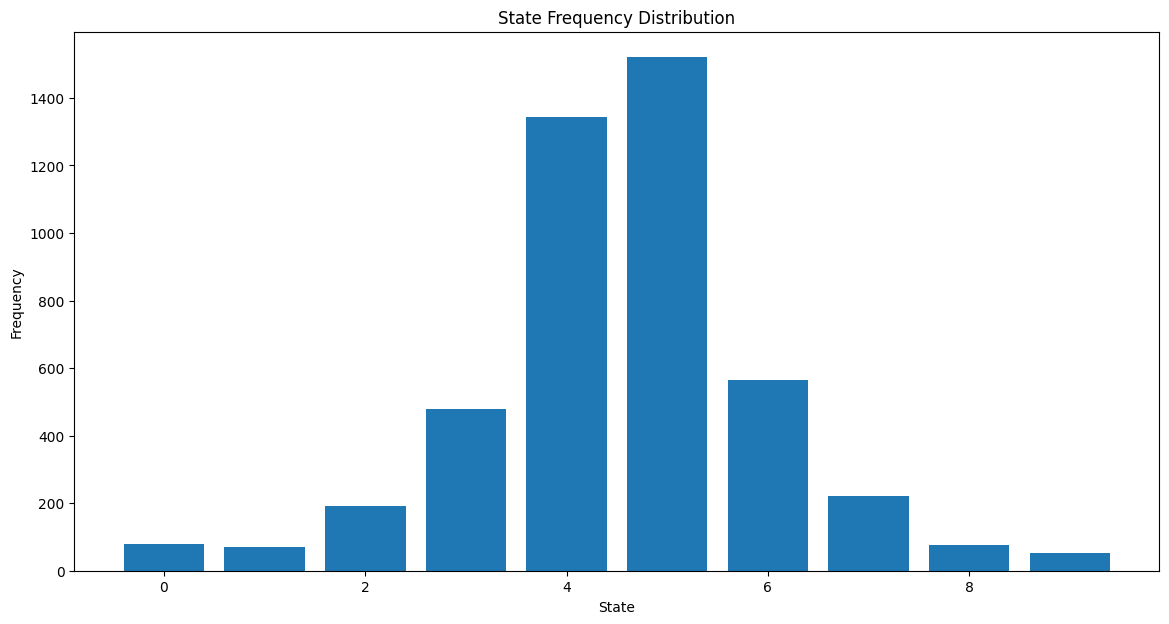

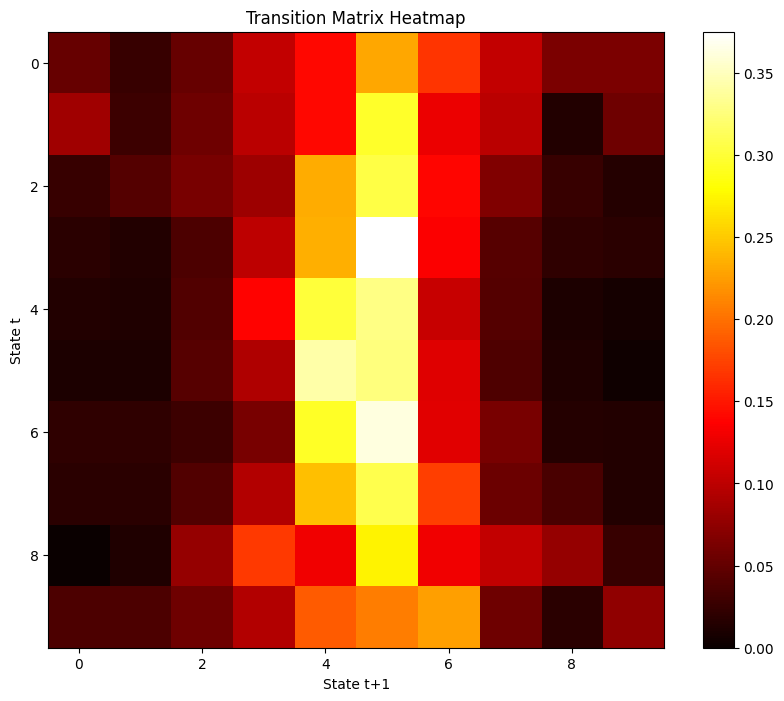

转移矩阵是否收敛: True, 收敛所需步数: 3


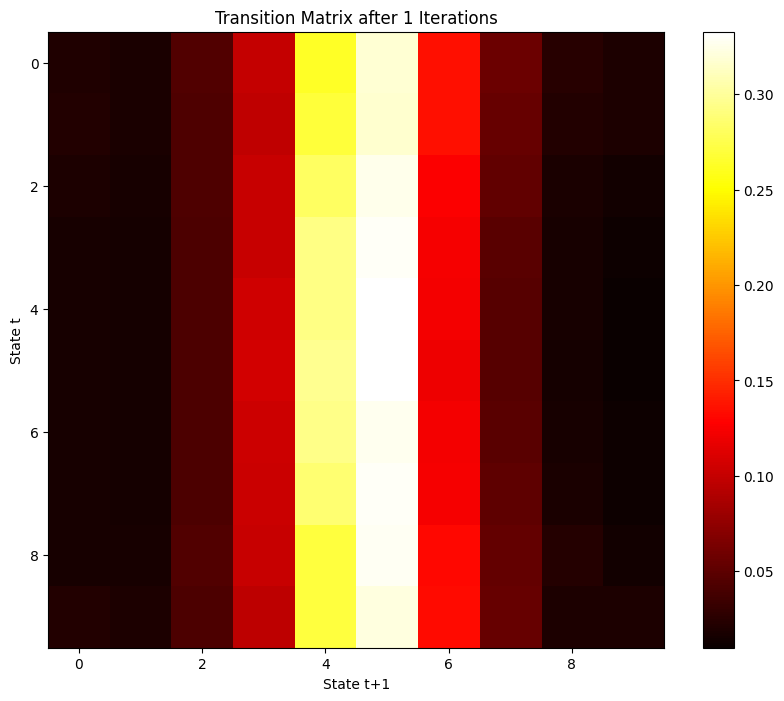

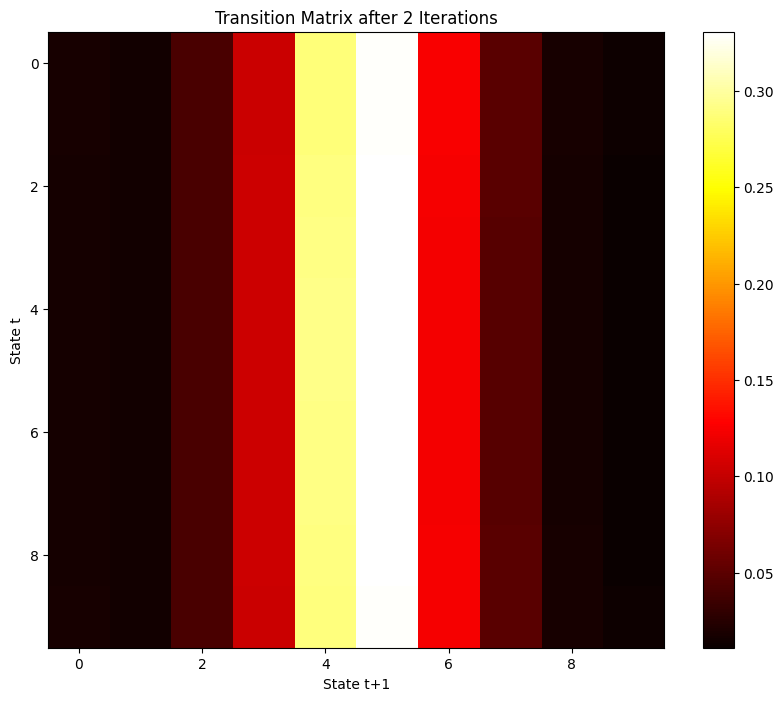

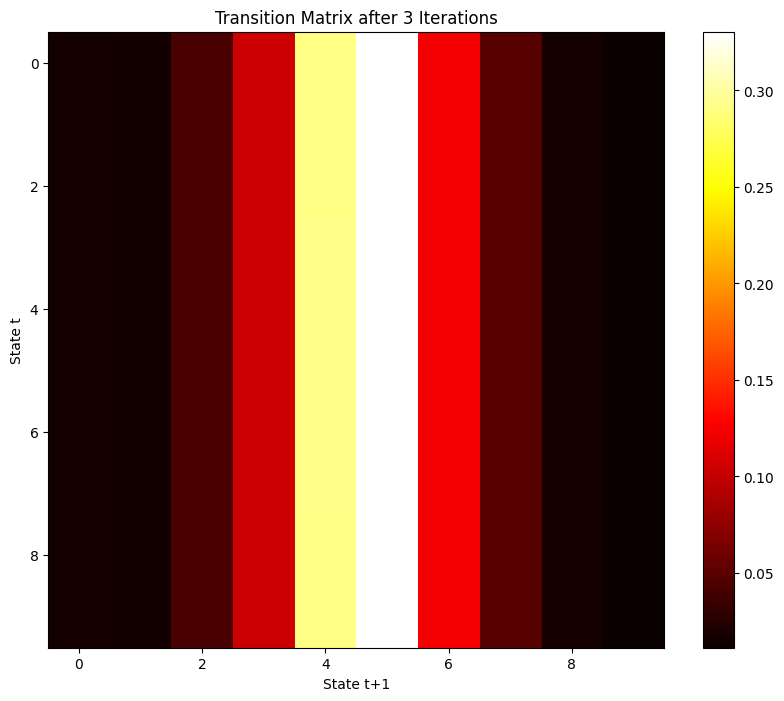

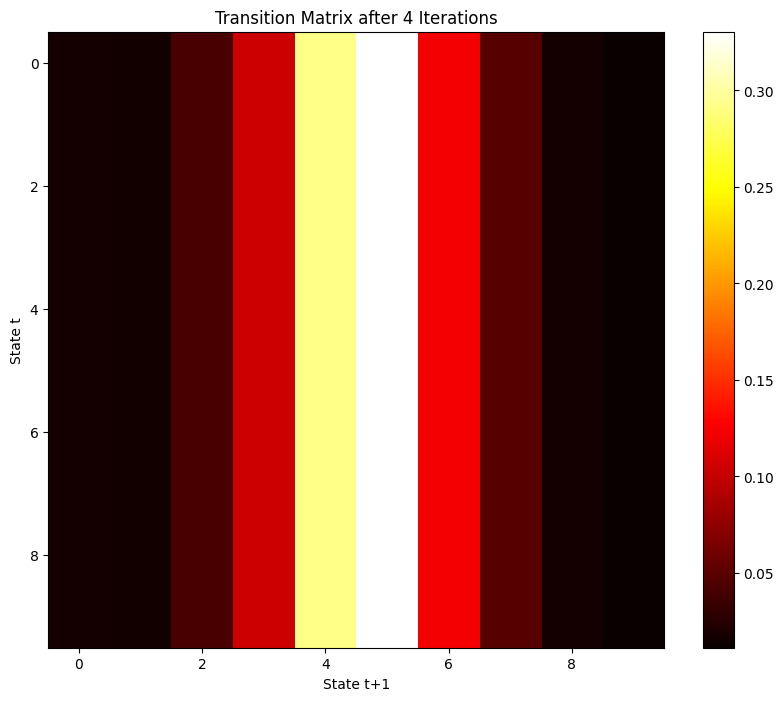

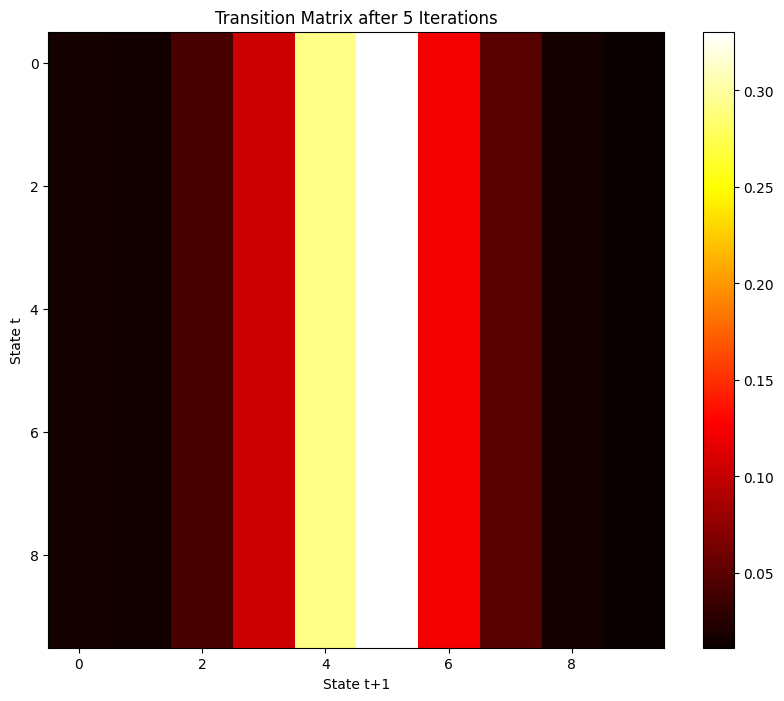

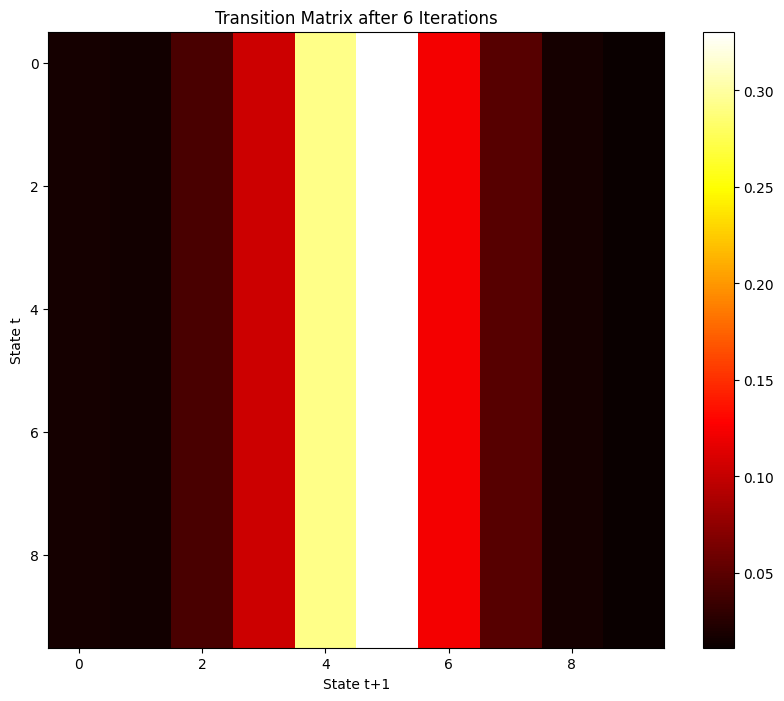

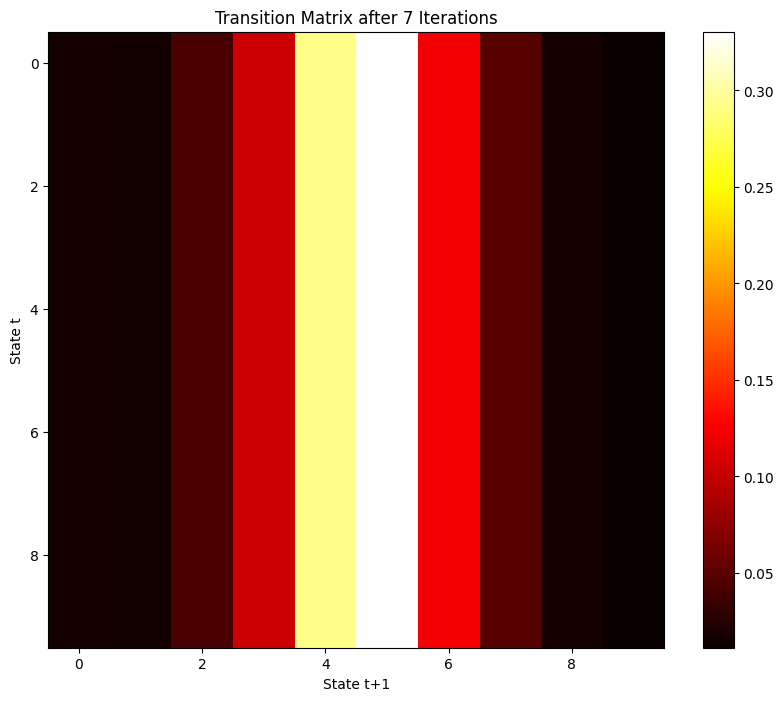

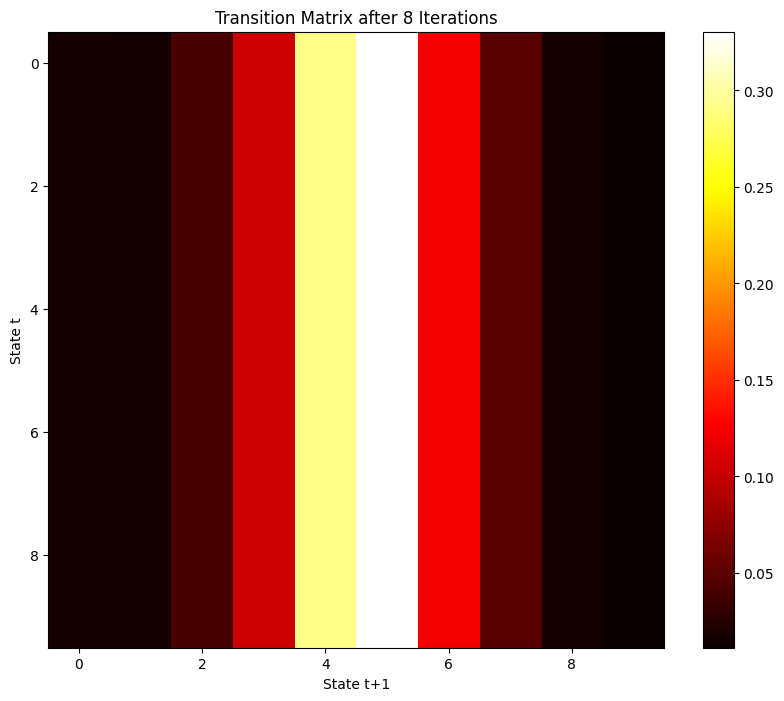

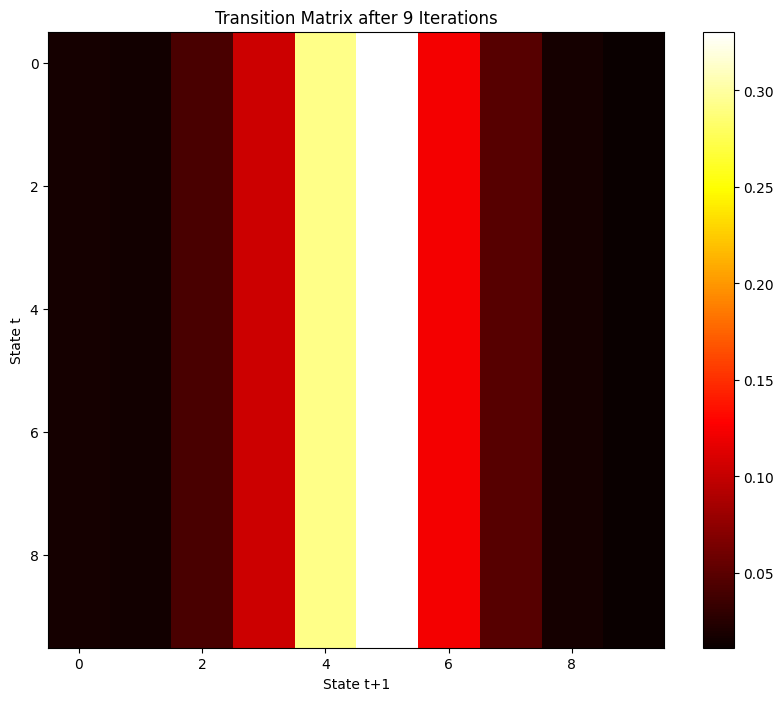

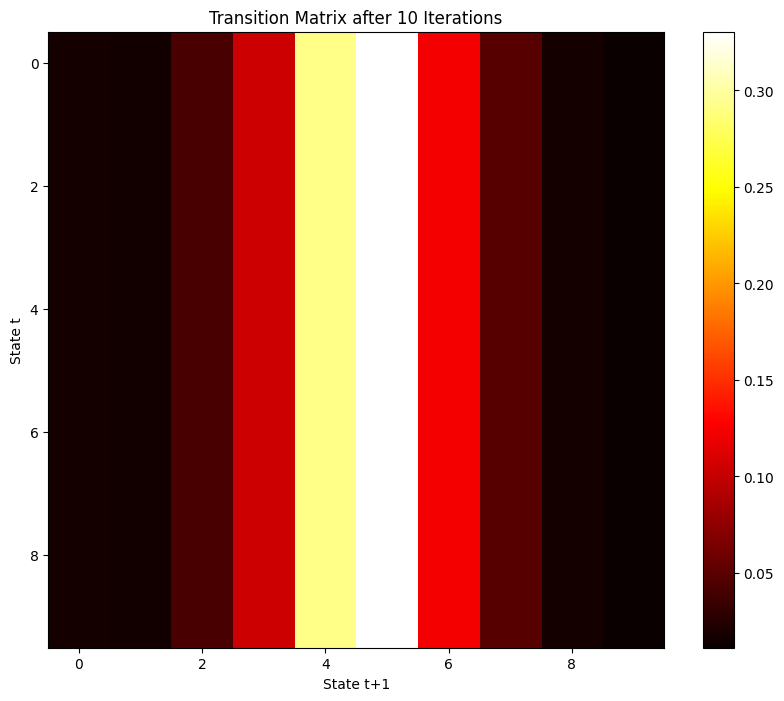

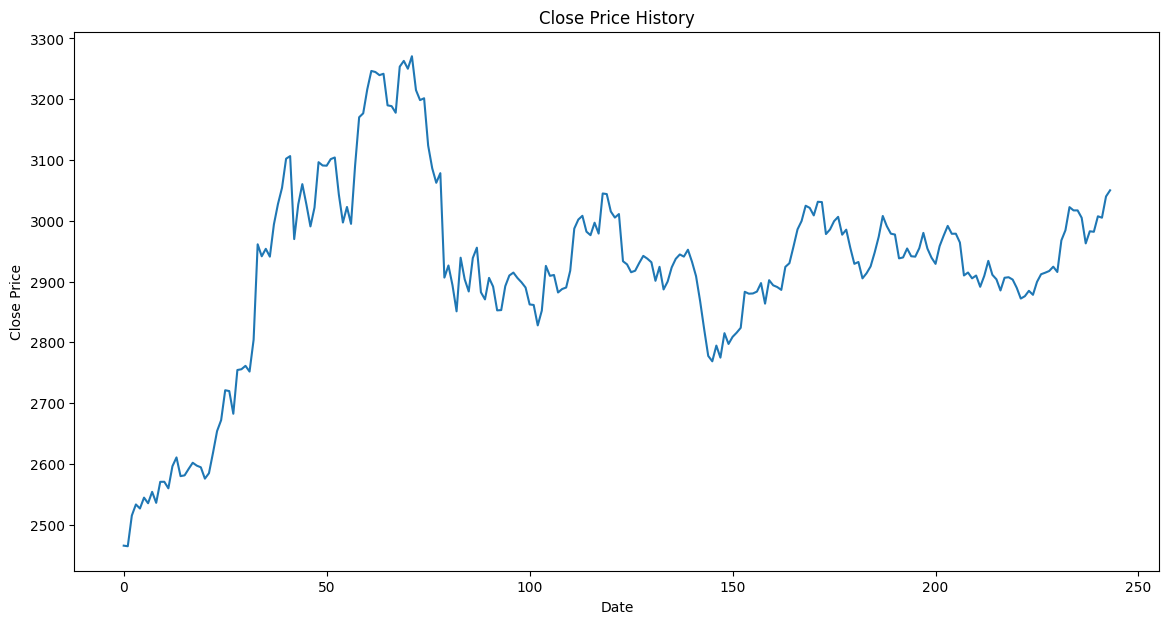

state 0: -5.00% ~ -4.00%
state 1: -4.00% ~ -3.00%
state 2: -3.00% ~ -2.00%
state 3: -2.00% ~ -1.00%
state 4: -1.00% ~ 0.00%
state 5: 0.00% ~ 1.00%
state 6: 1.00% ~ 2.00%
state 7: 2.00% ~ 3.00%
state 8: 3.00% ~ 4.00%
state 9: 4.00% ~ 5.00%


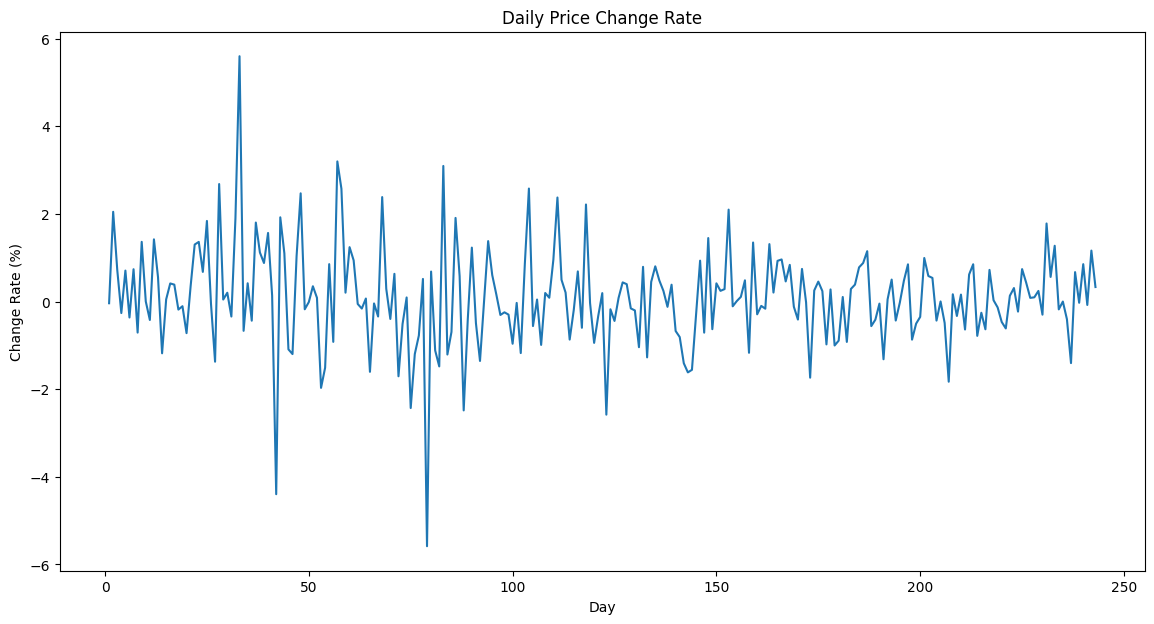

C:\Users\Li\AppData\Local\Temp\ipykernel_18828\1195700209.py:52: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


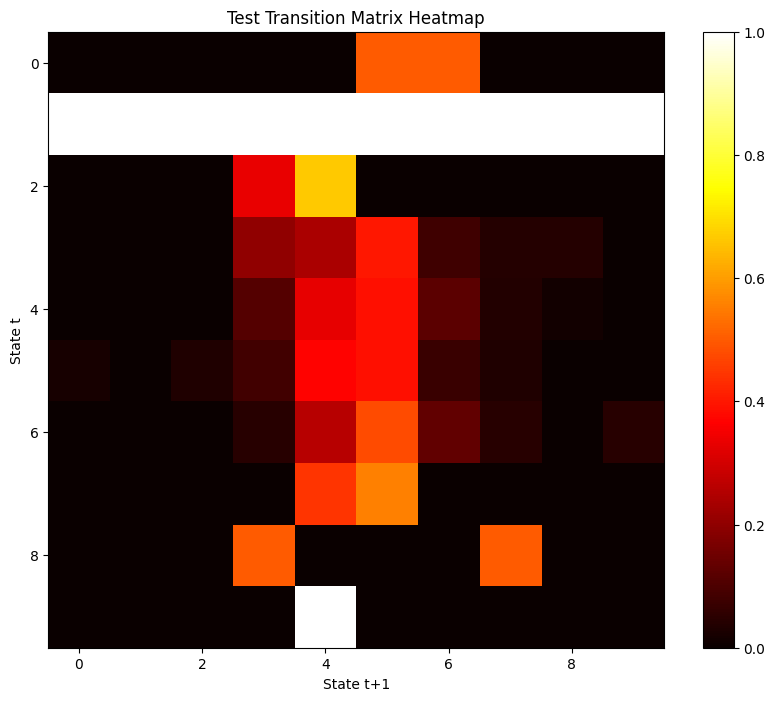

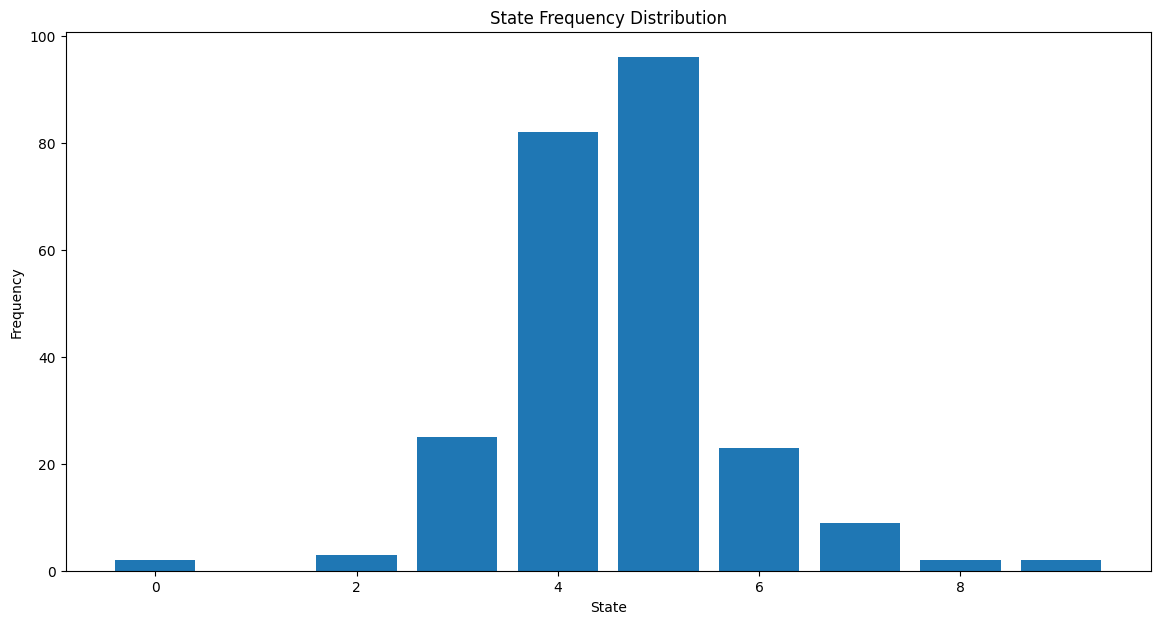

In [4]:
main('sh000001', '20000101', '20181231', '20190101', '20191231', N=10, lower_bound=-5, upper_bound=5)

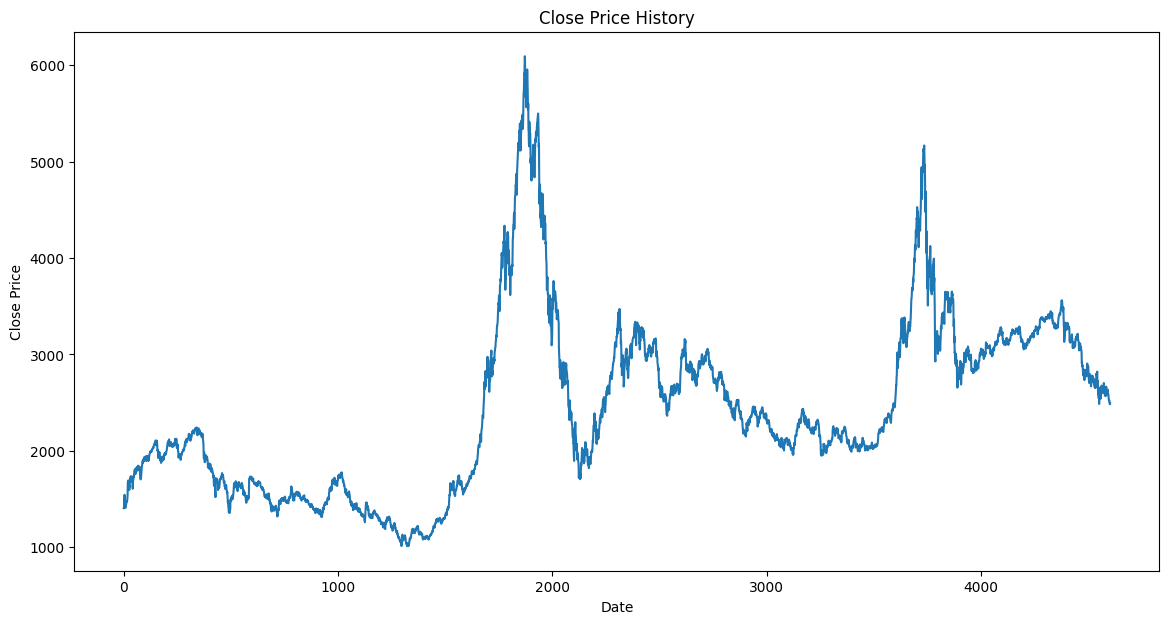

state 0: -5.00% ~ -4.80%
state 1: -4.80% ~ -4.60%
state 2: -4.60% ~ -4.40%
state 3: -4.40% ~ -4.20%
state 4: -4.20% ~ -4.00%
state 5: -4.00% ~ -3.80%
state 6: -3.80% ~ -3.60%
state 7: -3.60% ~ -3.40%
state 8: -3.40% ~ -3.20%
state 9: -3.20% ~ -3.00%
state 10: -3.00% ~ -2.80%
state 11: -2.80% ~ -2.60%
state 12: -2.60% ~ -2.40%
state 13: -2.40% ~ -2.20%
state 14: -2.20% ~ -2.00%
state 15: -2.00% ~ -1.80%
state 16: -1.80% ~ -1.60%
state 17: -1.60% ~ -1.40%
state 18: -1.40% ~ -1.20%
state 19: -1.20% ~ -1.00%
state 20: -1.00% ~ -0.80%
state 21: -0.80% ~ -0.60%
state 22: -0.60% ~ -0.40%
state 23: -0.40% ~ -0.20%
state 24: -0.20% ~ 0.00%
state 25: 0.00% ~ 0.20%
state 26: 0.20% ~ 0.40%
state 27: 0.40% ~ 0.60%
state 28: 0.60% ~ 0.80%
state 29: 0.80% ~ 1.00%
state 30: 1.00% ~ 1.20%
state 31: 1.20% ~ 1.40%
state 32: 1.40% ~ 1.60%
state 33: 1.60% ~ 1.80%
state 34: 1.80% ~ 2.00%
state 35: 2.00% ~ 2.20%
state 36: 2.20% ~ 2.40%
state 37: 2.40% ~ 2.60%
state 38: 2.60% ~ 2.80%
state 39: 2.80% ~ 3.00%
s

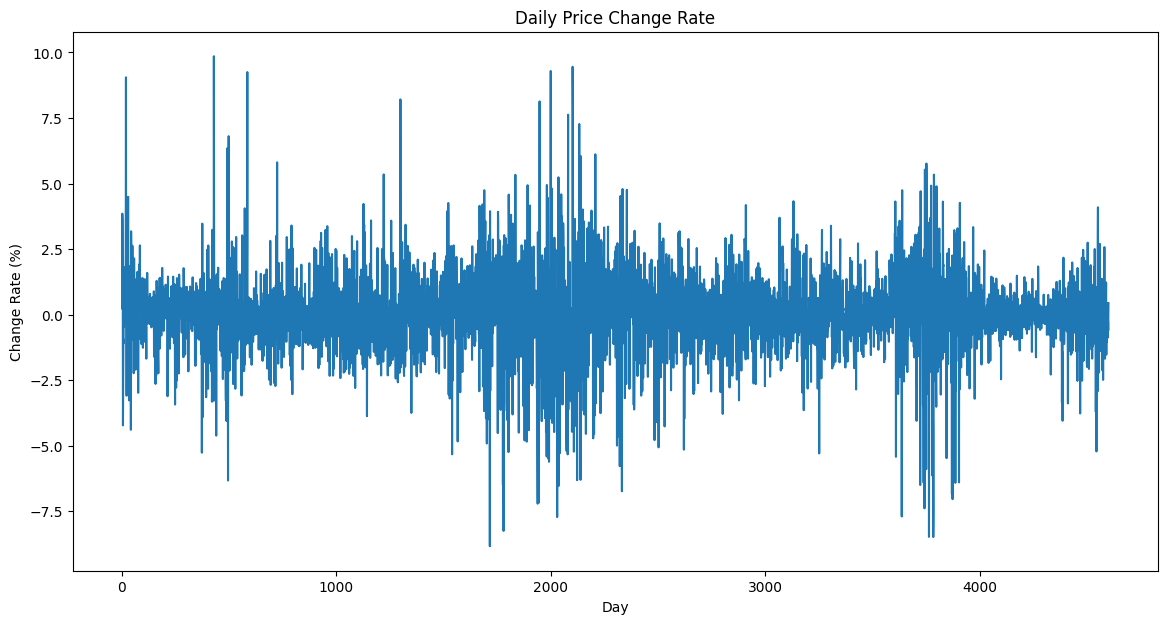

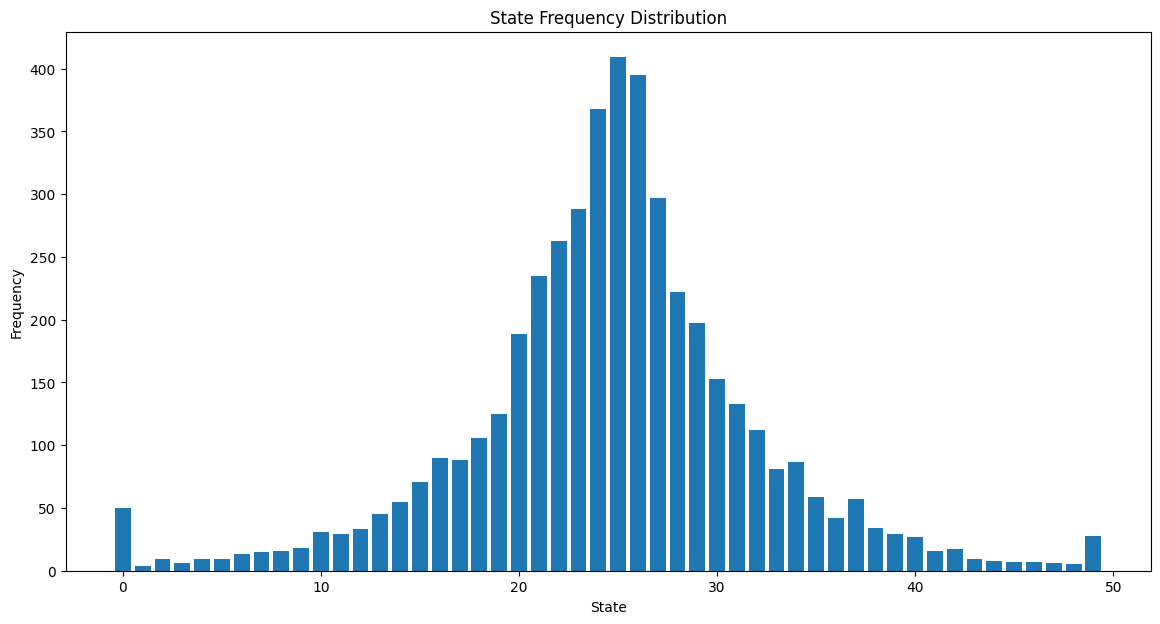

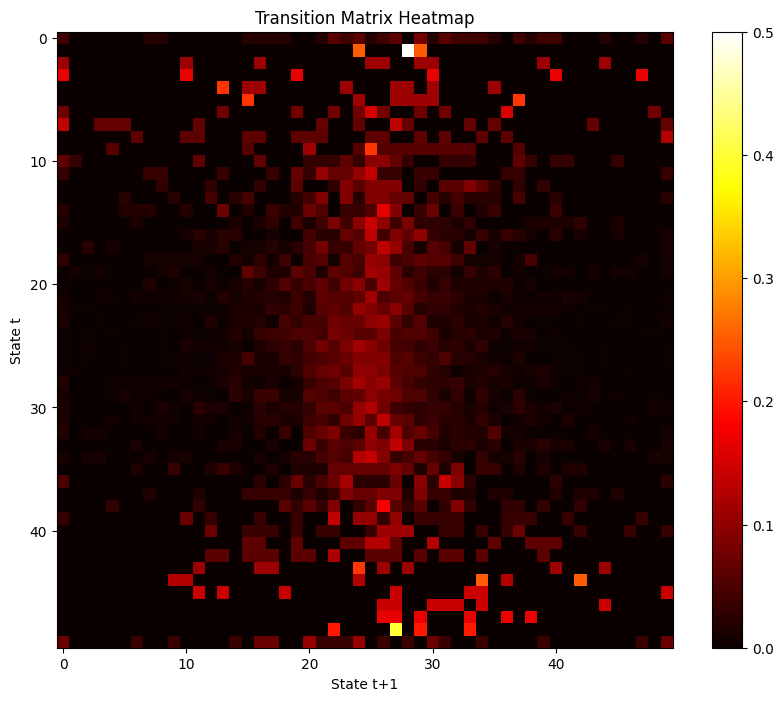

转移矩阵是否收敛: True, 收敛所需步数: 3


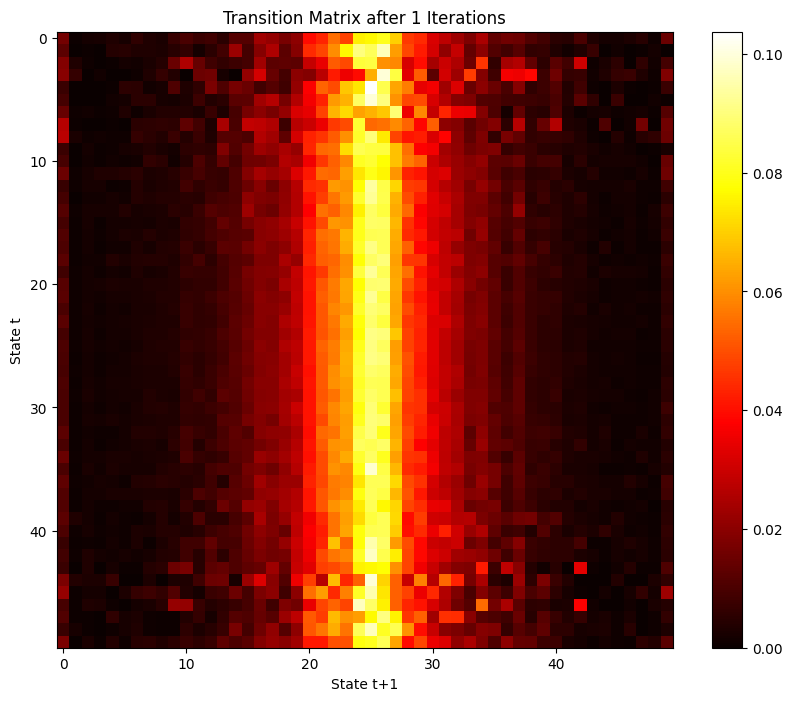

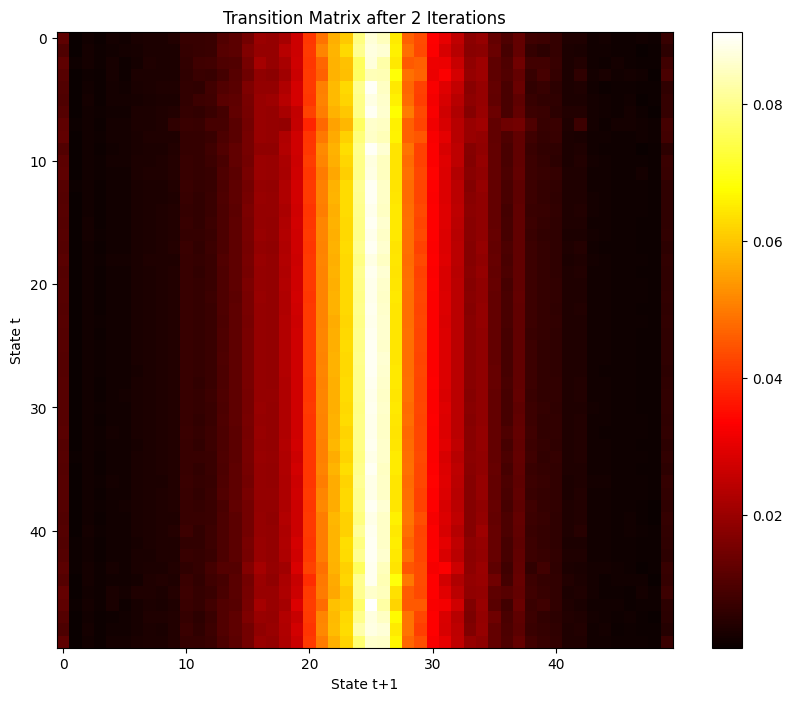

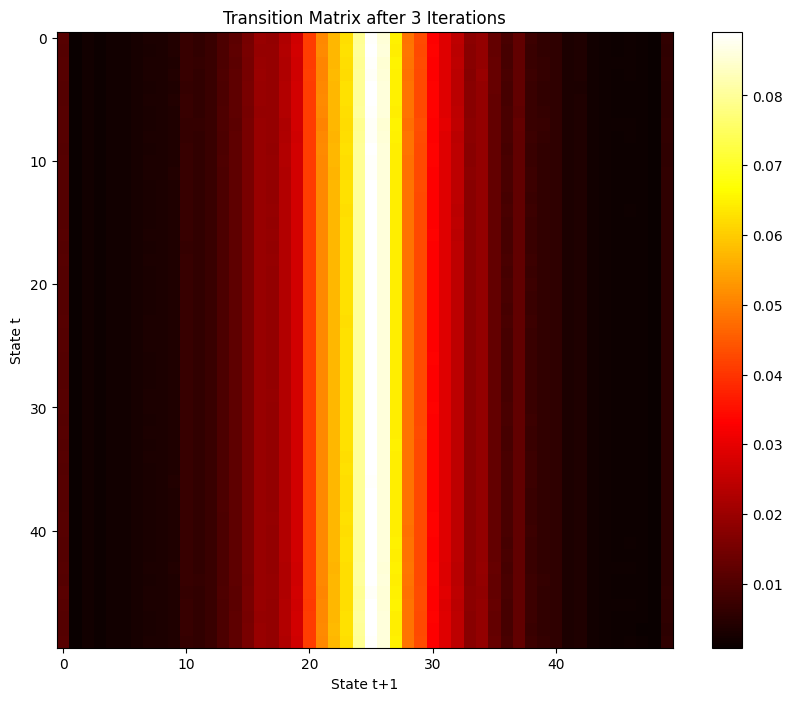

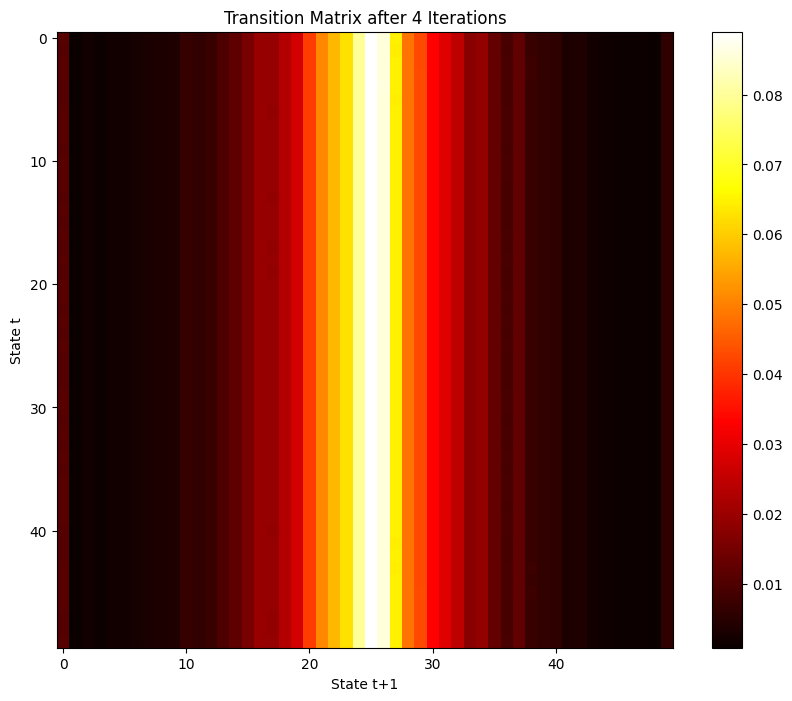

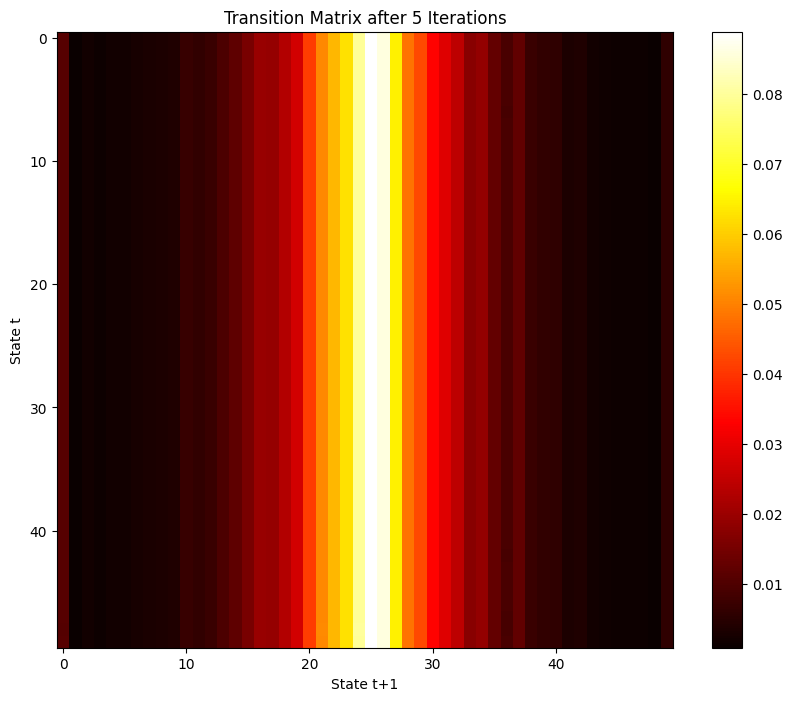

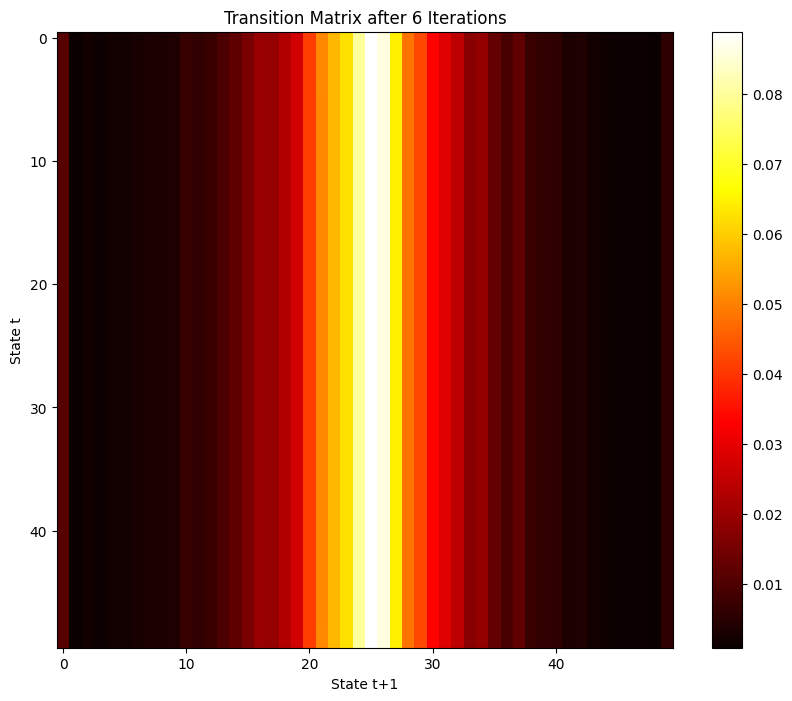

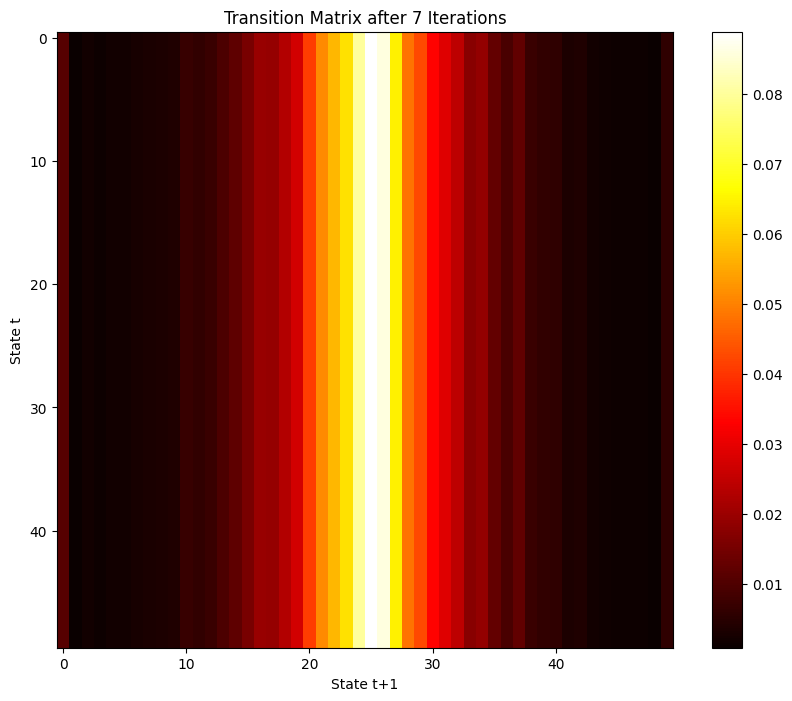

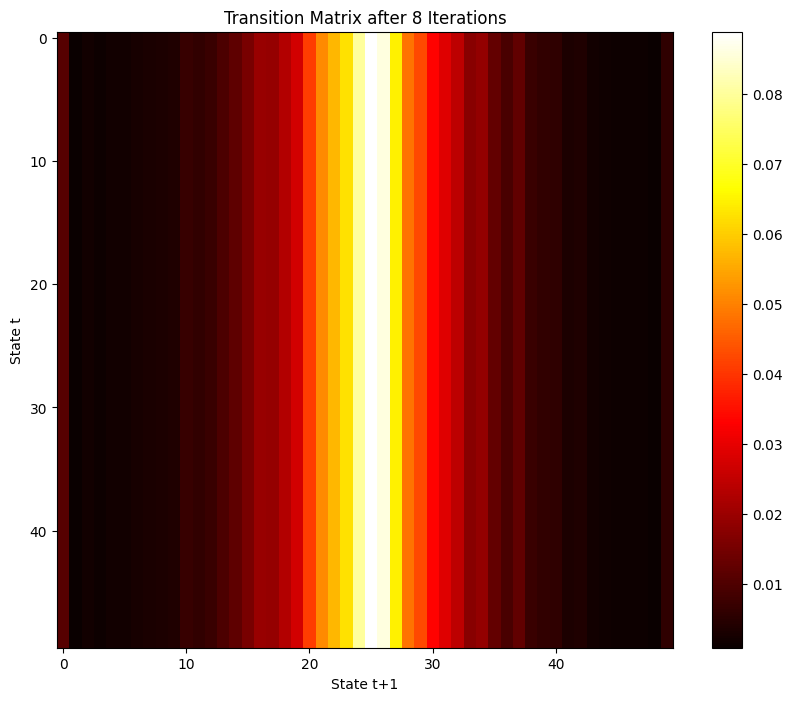

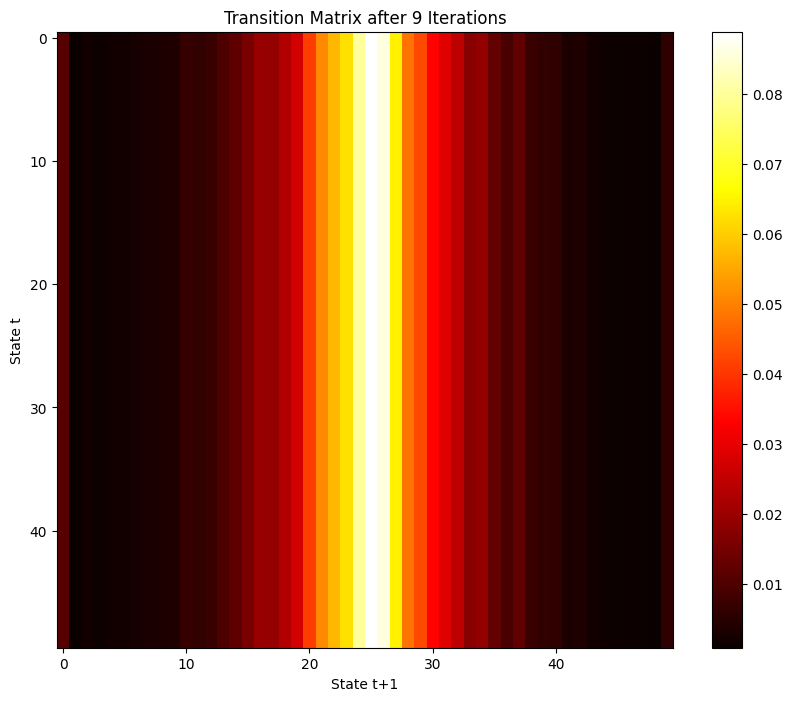

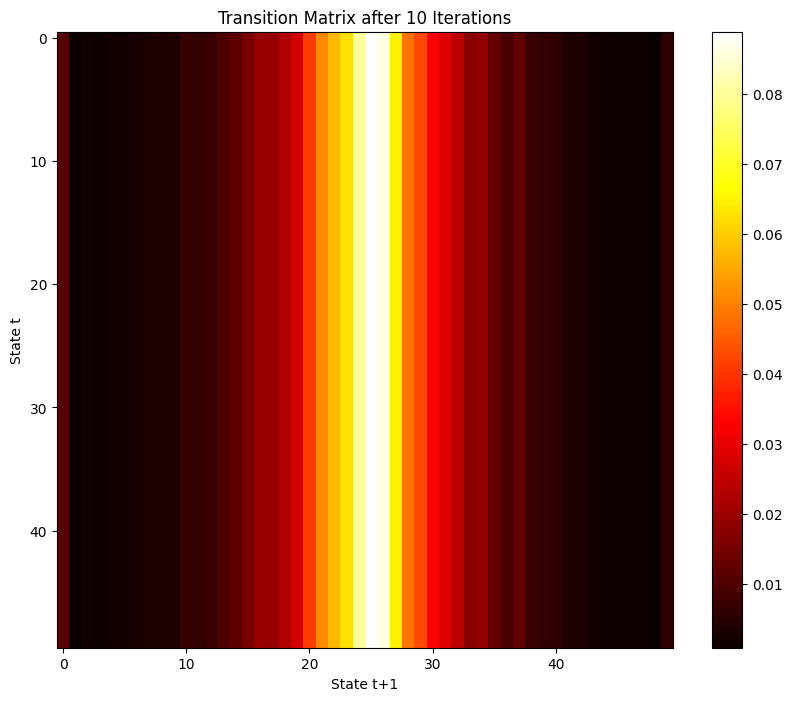

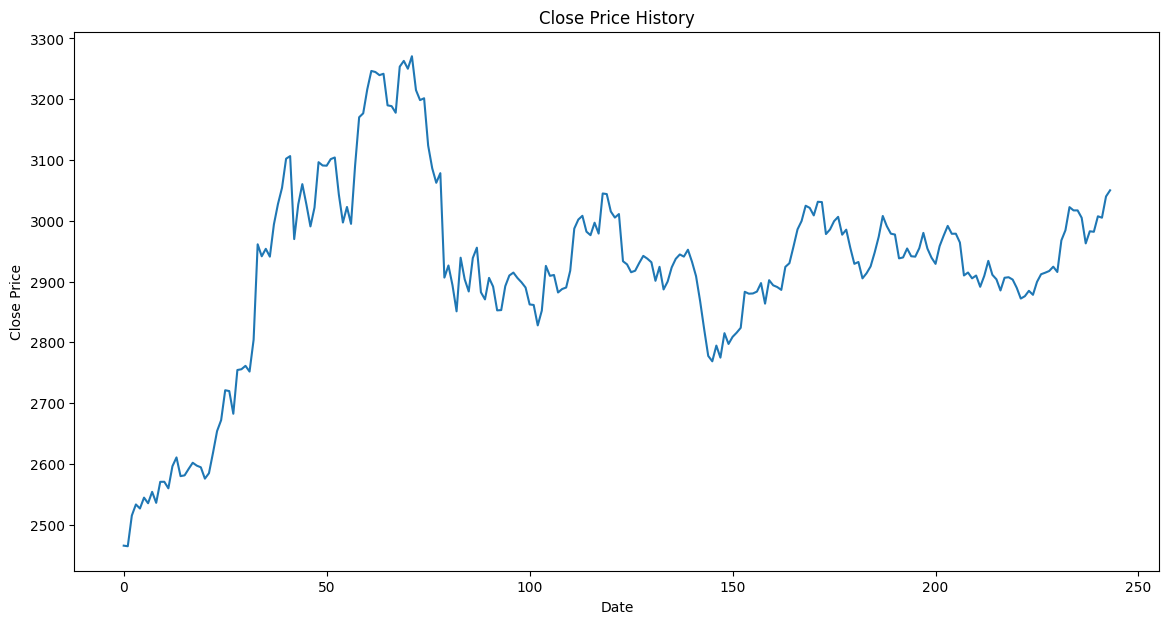

state 0: -5.00% ~ -4.80%
state 1: -4.80% ~ -4.60%
state 2: -4.60% ~ -4.40%
state 3: -4.40% ~ -4.20%
state 4: -4.20% ~ -4.00%
state 5: -4.00% ~ -3.80%
state 6: -3.80% ~ -3.60%
state 7: -3.60% ~ -3.40%
state 8: -3.40% ~ -3.20%
state 9: -3.20% ~ -3.00%
state 10: -3.00% ~ -2.80%
state 11: -2.80% ~ -2.60%
state 12: -2.60% ~ -2.40%
state 13: -2.40% ~ -2.20%
state 14: -2.20% ~ -2.00%
state 15: -2.00% ~ -1.80%
state 16: -1.80% ~ -1.60%
state 17: -1.60% ~ -1.40%
state 18: -1.40% ~ -1.20%
state 19: -1.20% ~ -1.00%
state 20: -1.00% ~ -0.80%
state 21: -0.80% ~ -0.60%
state 22: -0.60% ~ -0.40%
state 23: -0.40% ~ -0.20%
state 24: -0.20% ~ 0.00%
state 25: 0.00% ~ 0.20%
state 26: 0.20% ~ 0.40%
state 27: 0.40% ~ 0.60%
state 28: 0.60% ~ 0.80%
state 29: 0.80% ~ 1.00%
state 30: 1.00% ~ 1.20%
state 31: 1.20% ~ 1.40%
state 32: 1.40% ~ 1.60%
state 33: 1.60% ~ 1.80%
state 34: 1.80% ~ 2.00%
state 35: 2.00% ~ 2.20%
state 36: 2.20% ~ 2.40%
state 37: 2.40% ~ 2.60%
state 38: 2.60% ~ 2.80%
state 39: 2.80% ~ 3.00%
s

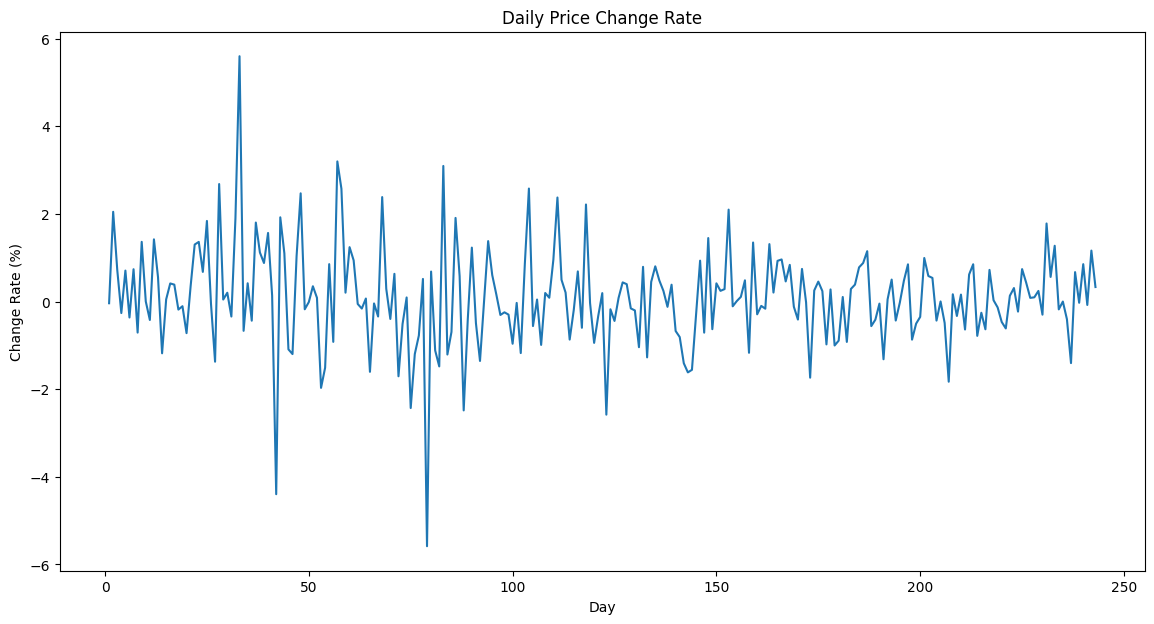

C:\Users\Li\AppData\Local\Temp\ipykernel_18828\1195700209.py:52: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


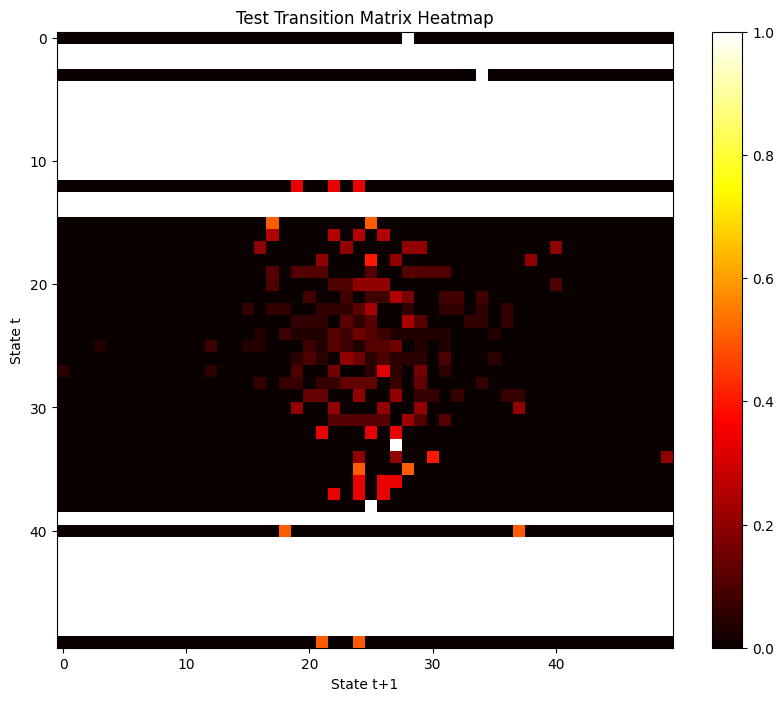

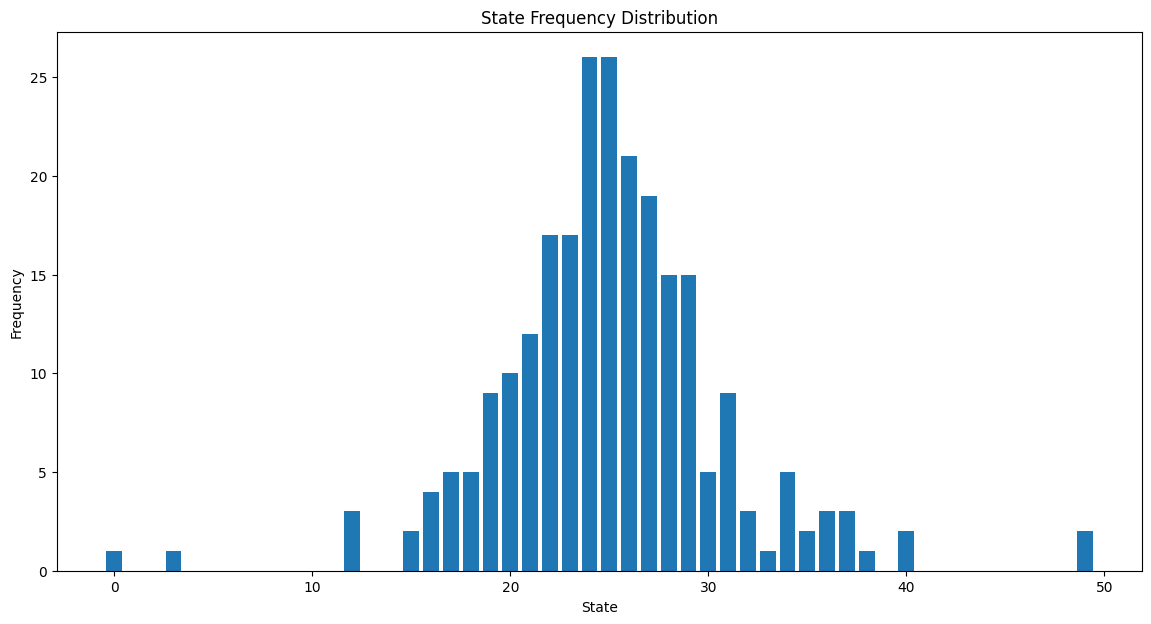

In [9]:
main('sh000001', '20000101', '20181231', '20190101', '20191231', N=50, lower_bound=-5, upper_bound=5)

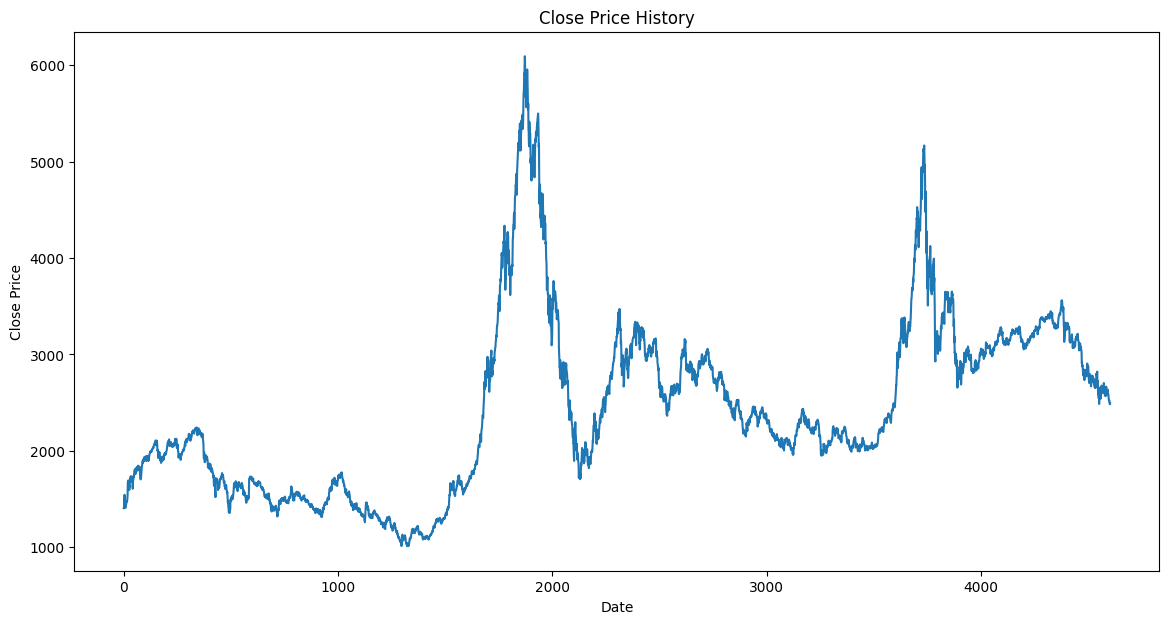

state 0: -10.00% ~ -9.80%
state 1: -9.80% ~ -9.60%
state 2: -9.60% ~ -9.40%
state 3: -9.40% ~ -9.20%
state 4: -9.20% ~ -9.00%
state 5: -9.00% ~ -8.80%
state 6: -8.80% ~ -8.60%
state 7: -8.60% ~ -8.40%
state 8: -8.40% ~ -8.20%
state 9: -8.20% ~ -8.00%
state 10: -8.00% ~ -7.80%
state 11: -7.80% ~ -7.60%
state 12: -7.60% ~ -7.40%
state 13: -7.40% ~ -7.20%
state 14: -7.20% ~ -7.00%
state 15: -7.00% ~ -6.80%
state 16: -6.80% ~ -6.60%
state 17: -6.60% ~ -6.40%
state 18: -6.40% ~ -6.20%
state 19: -6.20% ~ -6.00%
state 20: -6.00% ~ -5.80%
state 21: -5.80% ~ -5.60%
state 22: -5.60% ~ -5.40%
state 23: -5.40% ~ -5.20%
state 24: -5.20% ~ -5.00%
state 25: -5.00% ~ -4.80%
state 26: -4.80% ~ -4.60%
state 27: -4.60% ~ -4.40%
state 28: -4.40% ~ -4.20%
state 29: -4.20% ~ -4.00%
state 30: -4.00% ~ -3.80%
state 31: -3.80% ~ -3.60%
state 32: -3.60% ~ -3.40%
state 33: -3.40% ~ -3.20%
state 34: -3.20% ~ -3.00%
state 35: -3.00% ~ -2.80%
state 36: -2.80% ~ -2.60%
state 37: -2.60% ~ -2.40%
state 38: -2.40% ~ -2

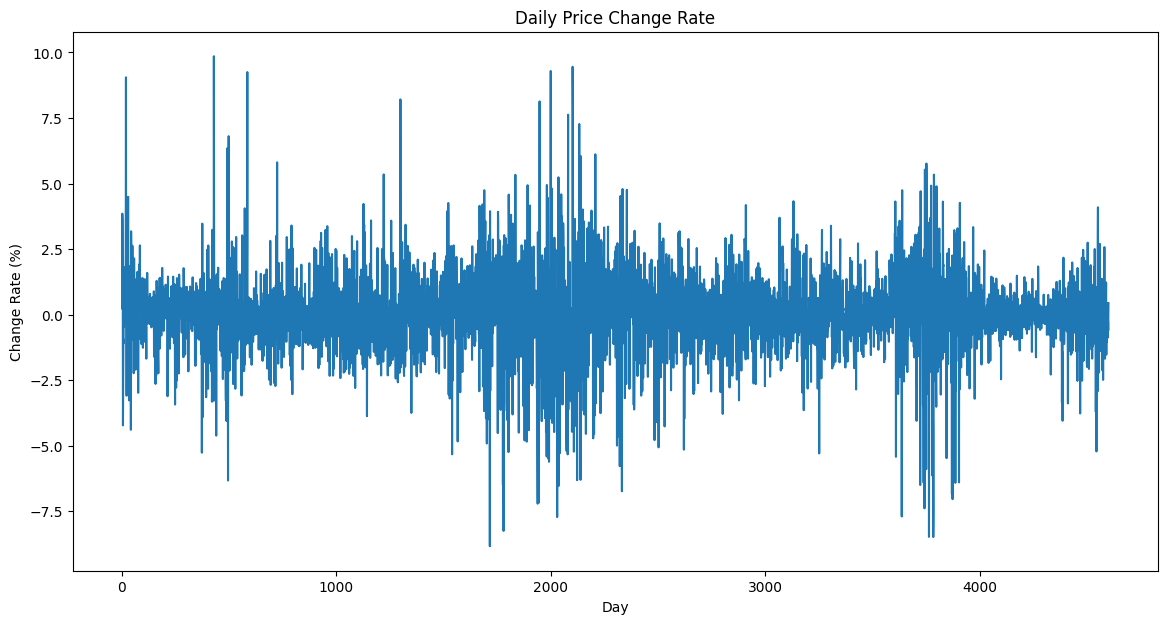

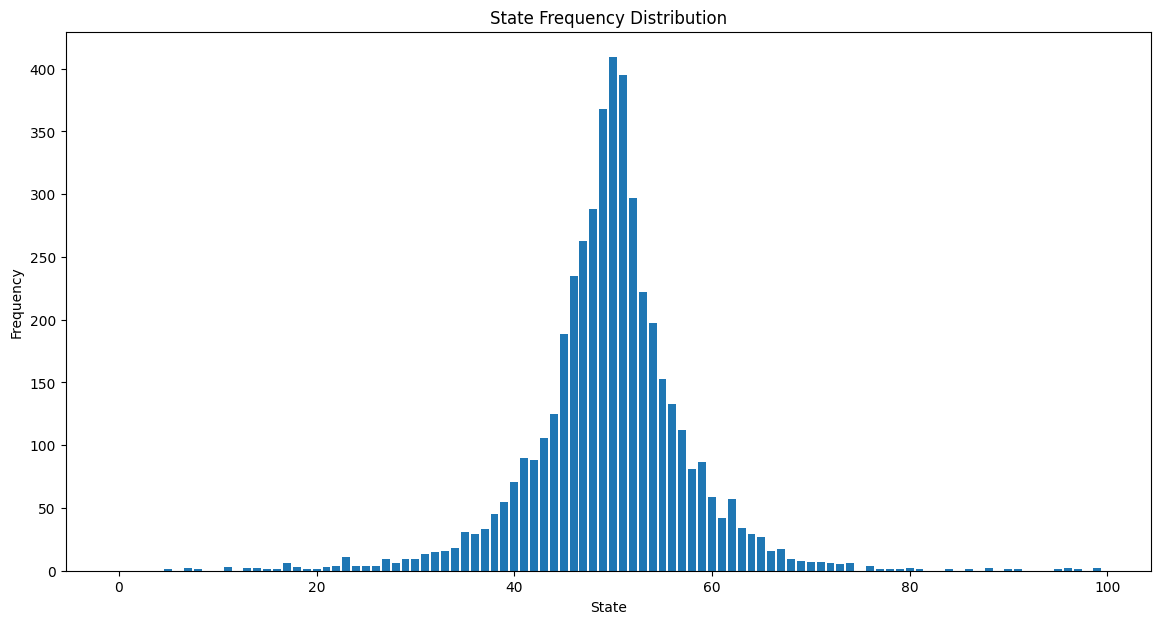

C:\Users\Li\AppData\Local\Temp\ipykernel_18828\1195700209.py:52: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


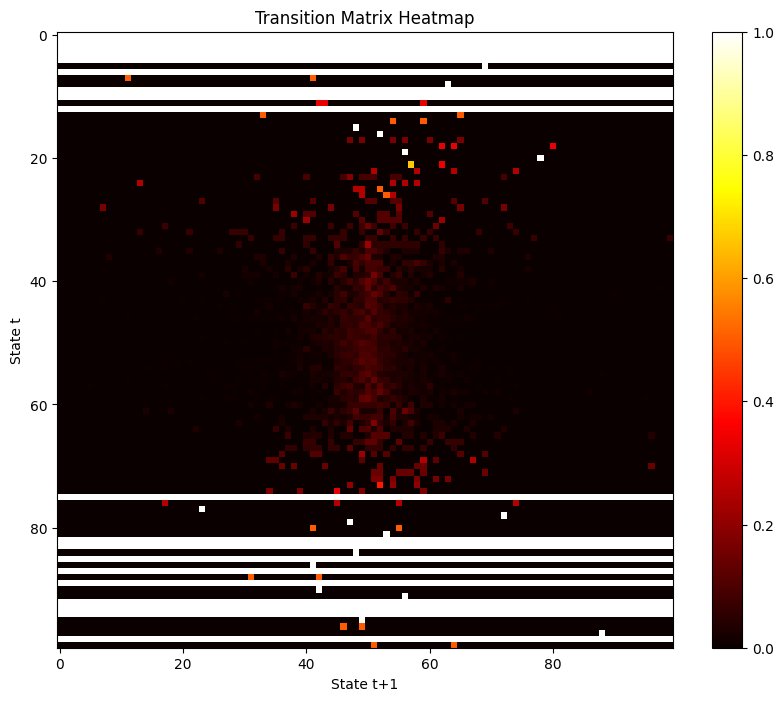

转移矩阵是否收敛: False, 收敛所需步数: 100


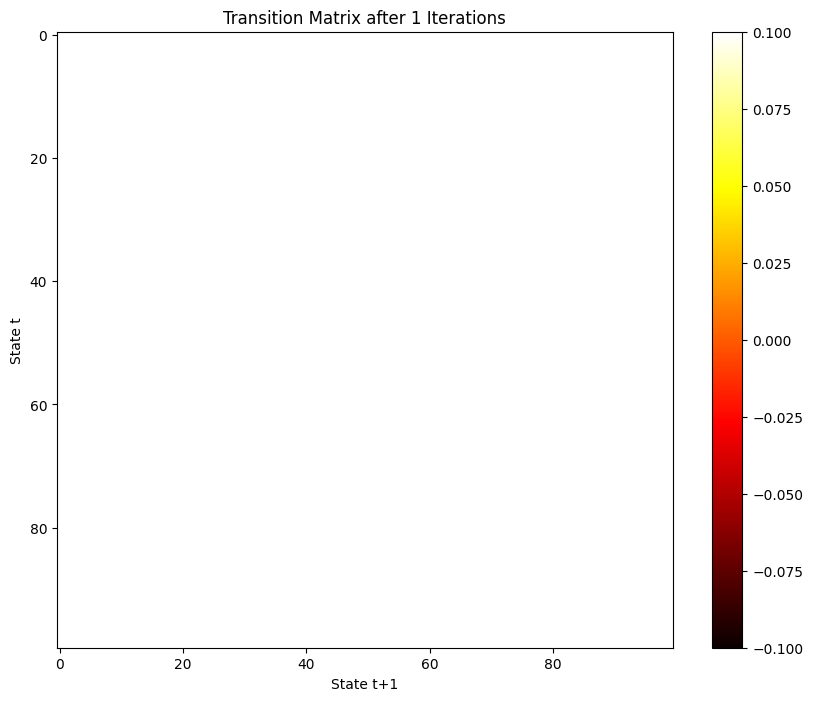

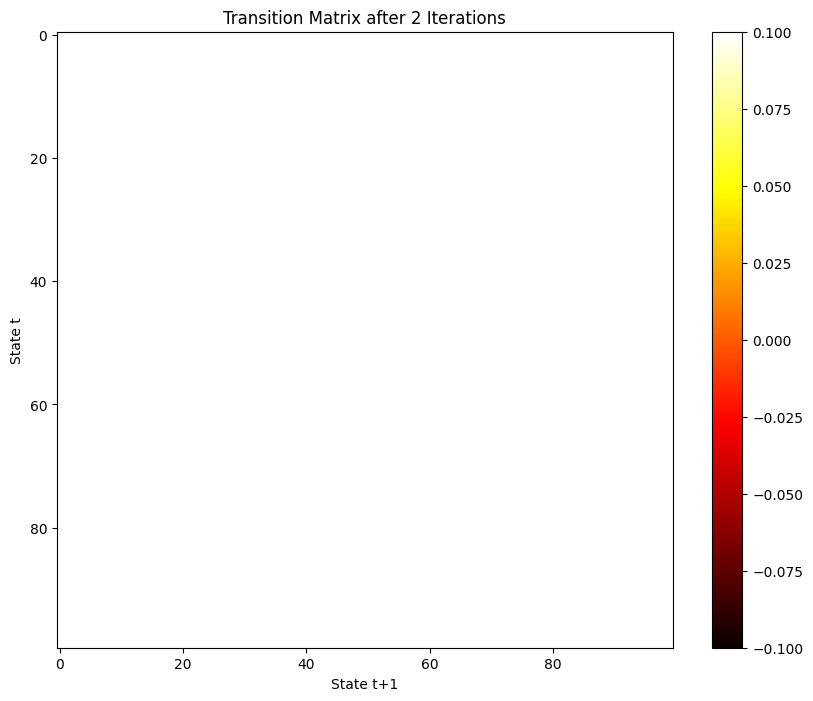

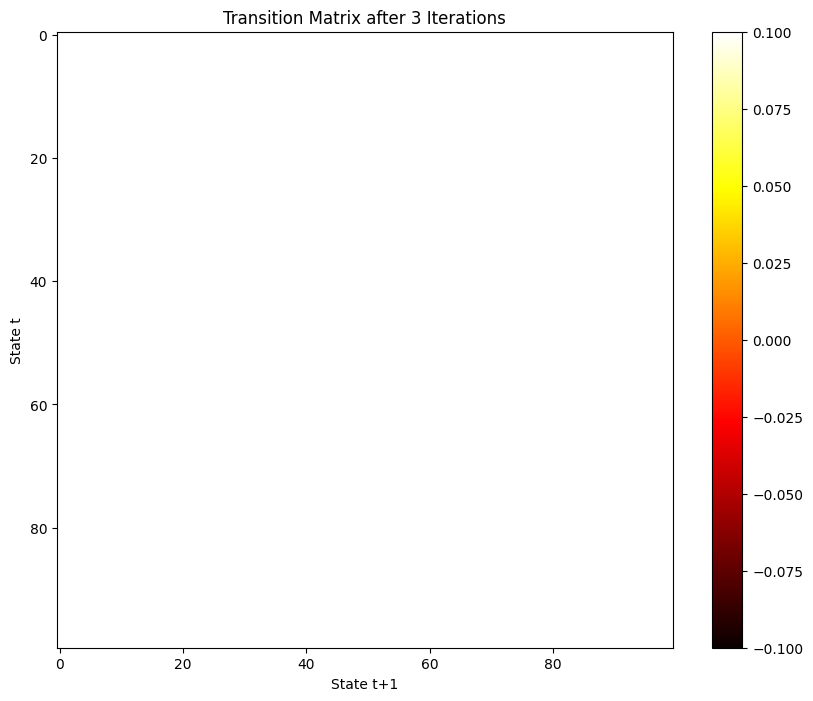

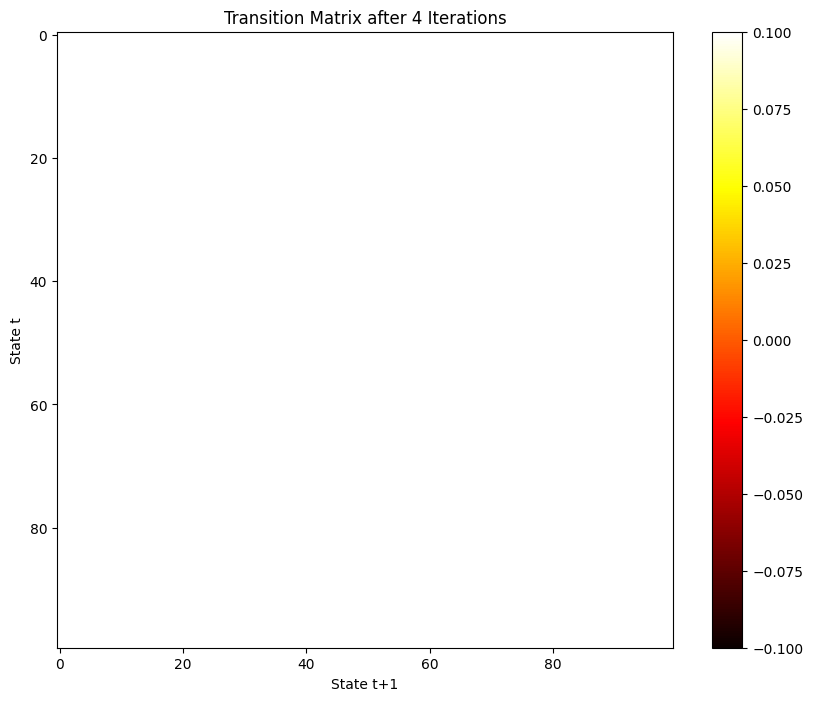

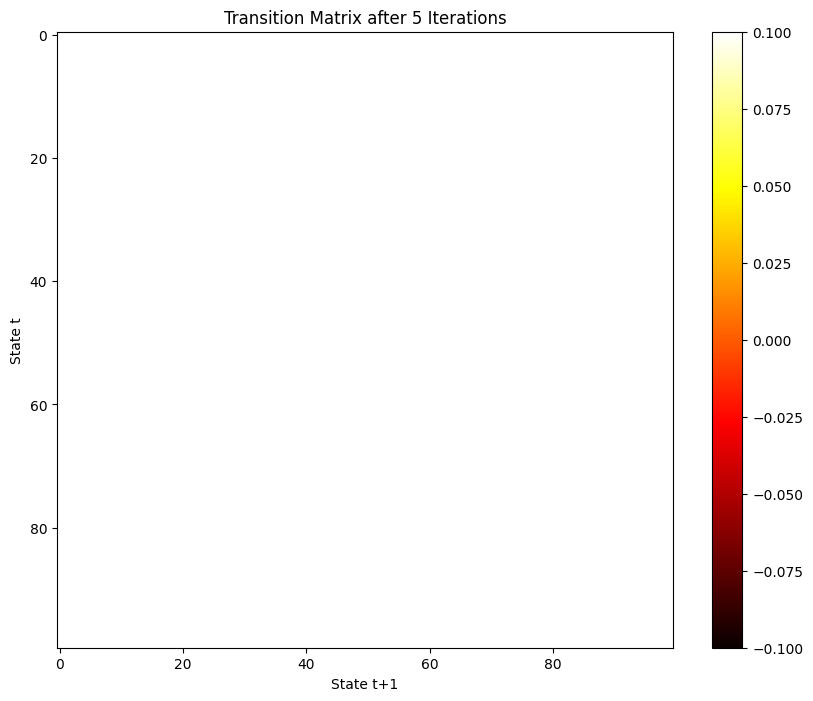

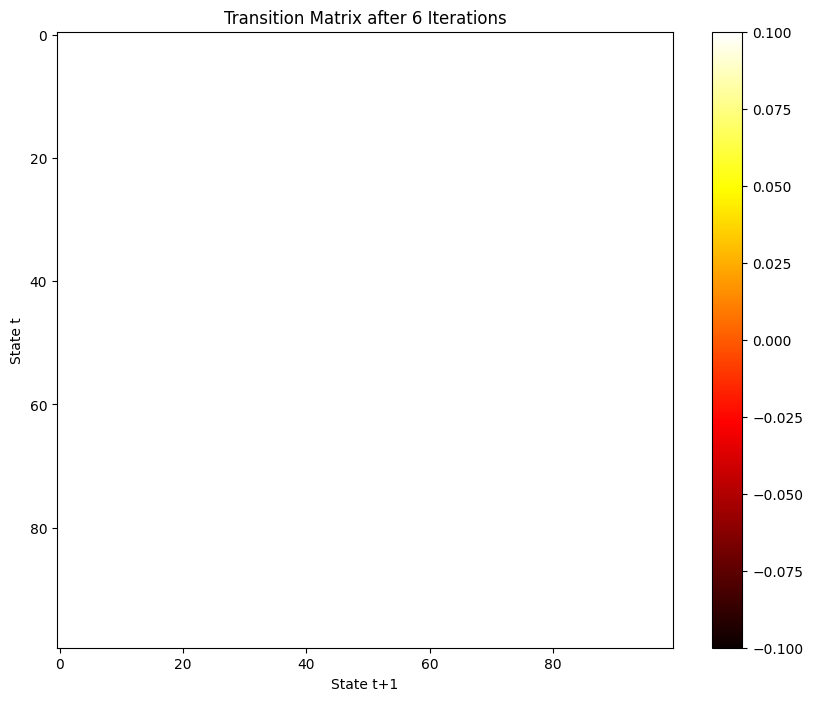

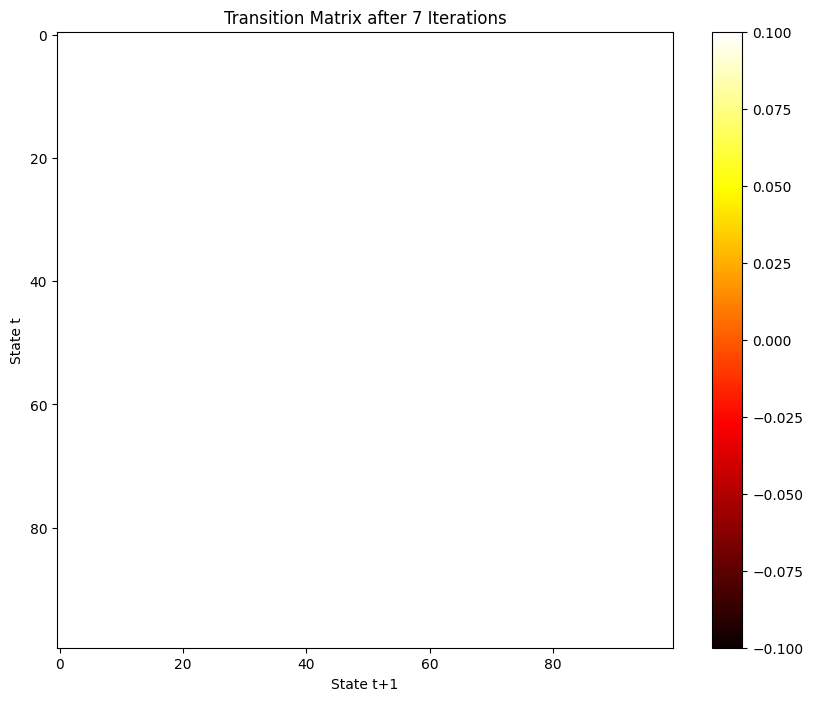

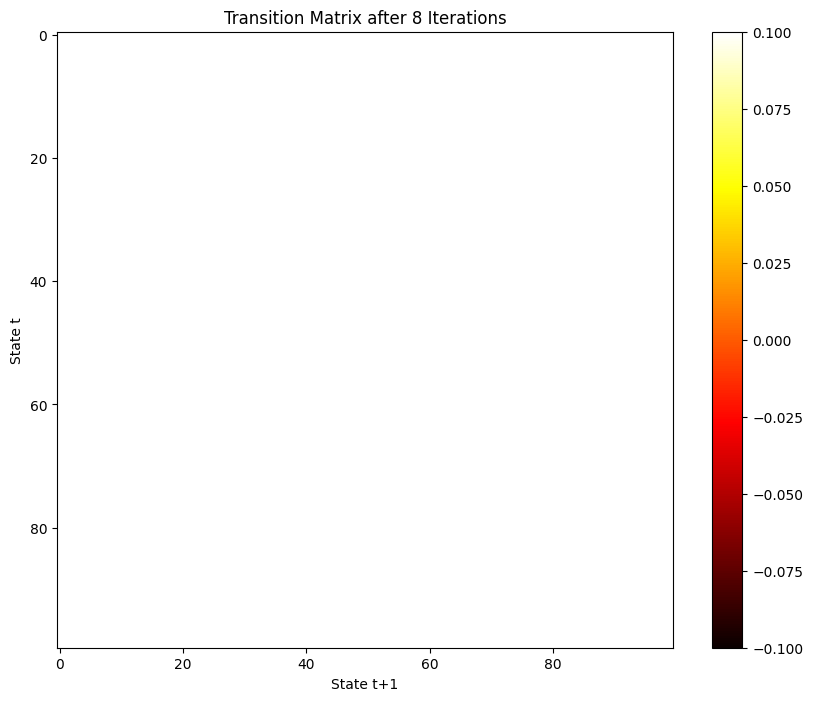

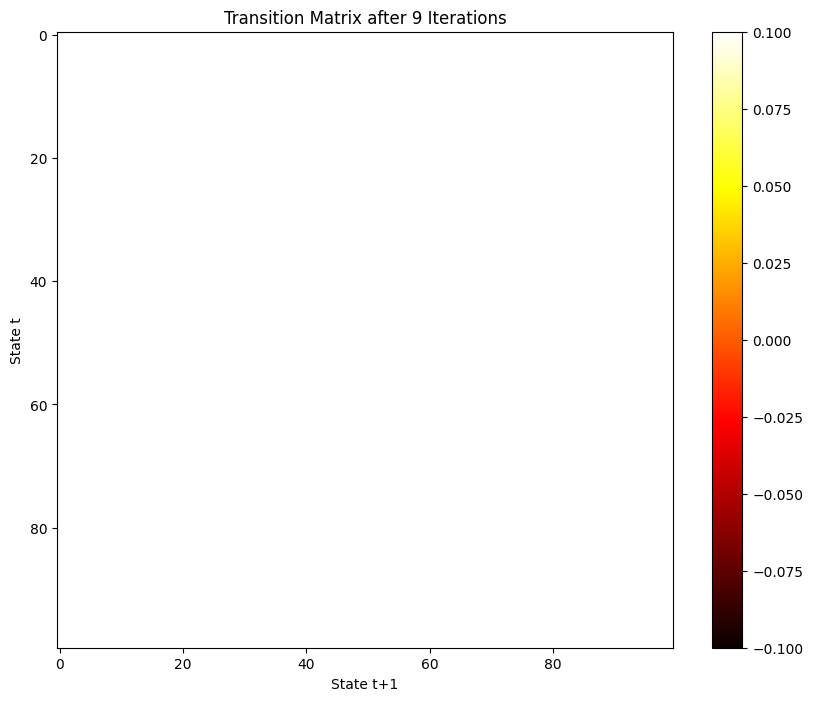

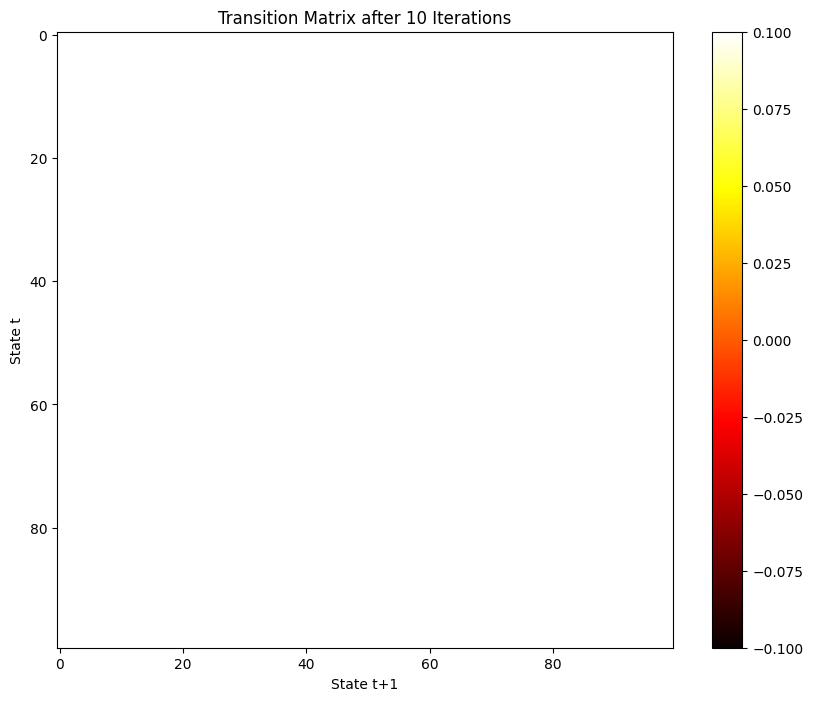

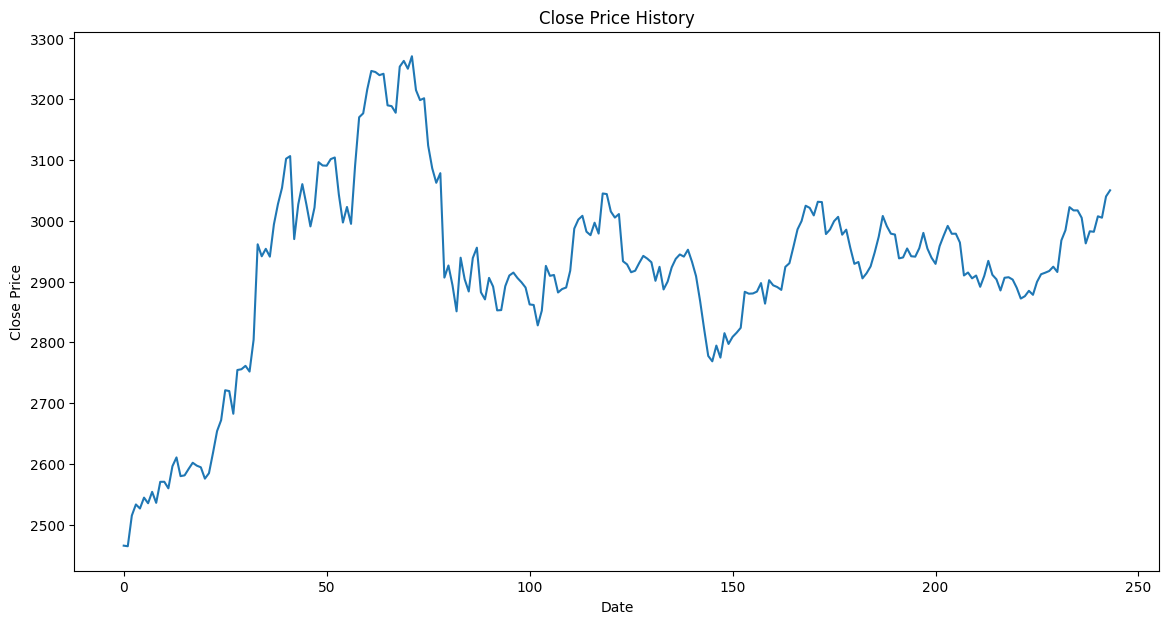

state 0: -10.00% ~ -9.80%
state 1: -9.80% ~ -9.60%
state 2: -9.60% ~ -9.40%
state 3: -9.40% ~ -9.20%
state 4: -9.20% ~ -9.00%
state 5: -9.00% ~ -8.80%
state 6: -8.80% ~ -8.60%
state 7: -8.60% ~ -8.40%
state 8: -8.40% ~ -8.20%
state 9: -8.20% ~ -8.00%
state 10: -8.00% ~ -7.80%
state 11: -7.80% ~ -7.60%
state 12: -7.60% ~ -7.40%
state 13: -7.40% ~ -7.20%
state 14: -7.20% ~ -7.00%
state 15: -7.00% ~ -6.80%
state 16: -6.80% ~ -6.60%
state 17: -6.60% ~ -6.40%
state 18: -6.40% ~ -6.20%
state 19: -6.20% ~ -6.00%
state 20: -6.00% ~ -5.80%
state 21: -5.80% ~ -5.60%
state 22: -5.60% ~ -5.40%
state 23: -5.40% ~ -5.20%
state 24: -5.20% ~ -5.00%
state 25: -5.00% ~ -4.80%
state 26: -4.80% ~ -4.60%
state 27: -4.60% ~ -4.40%
state 28: -4.40% ~ -4.20%
state 29: -4.20% ~ -4.00%
state 30: -4.00% ~ -3.80%
state 31: -3.80% ~ -3.60%
state 32: -3.60% ~ -3.40%
state 33: -3.40% ~ -3.20%
state 34: -3.20% ~ -3.00%
state 35: -3.00% ~ -2.80%
state 36: -2.80% ~ -2.60%
state 37: -2.60% ~ -2.40%
state 38: -2.40% ~ -2

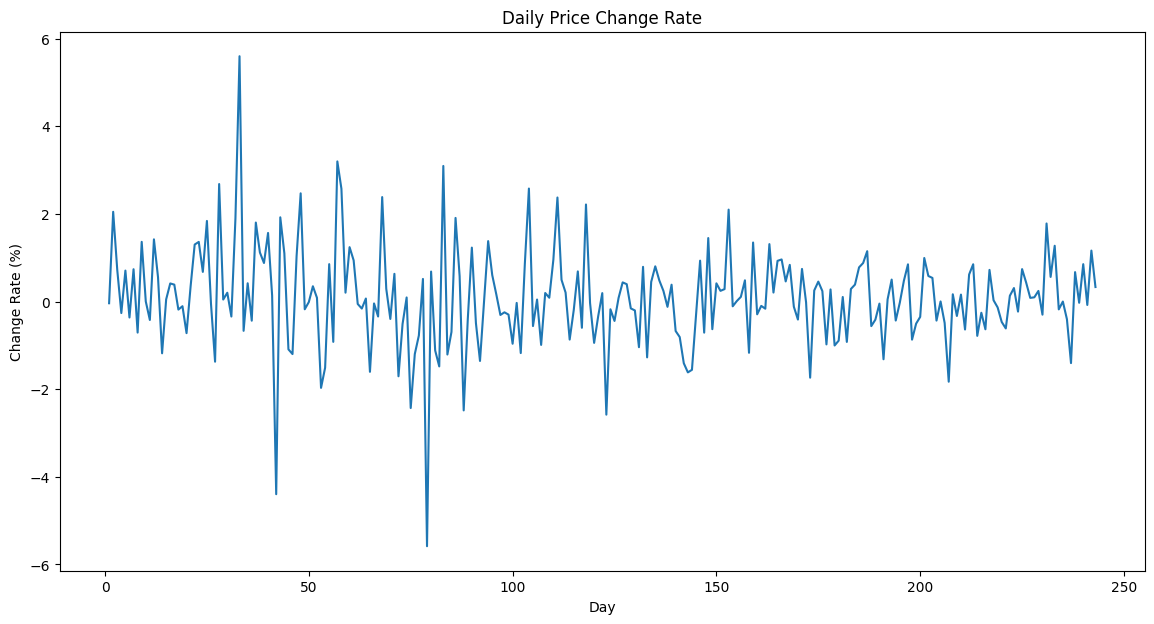

C:\Users\Li\AppData\Local\Temp\ipykernel_18828\1195700209.py:52: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


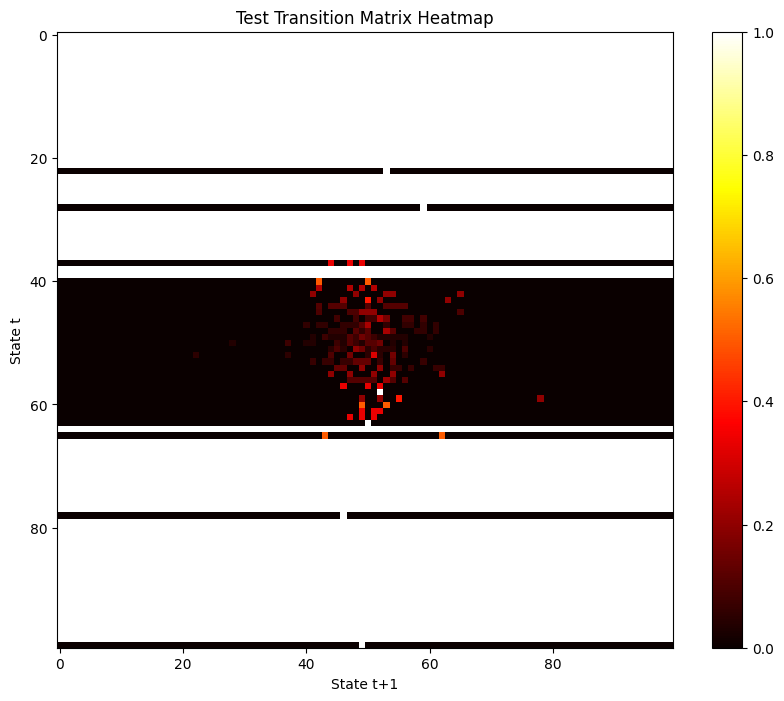

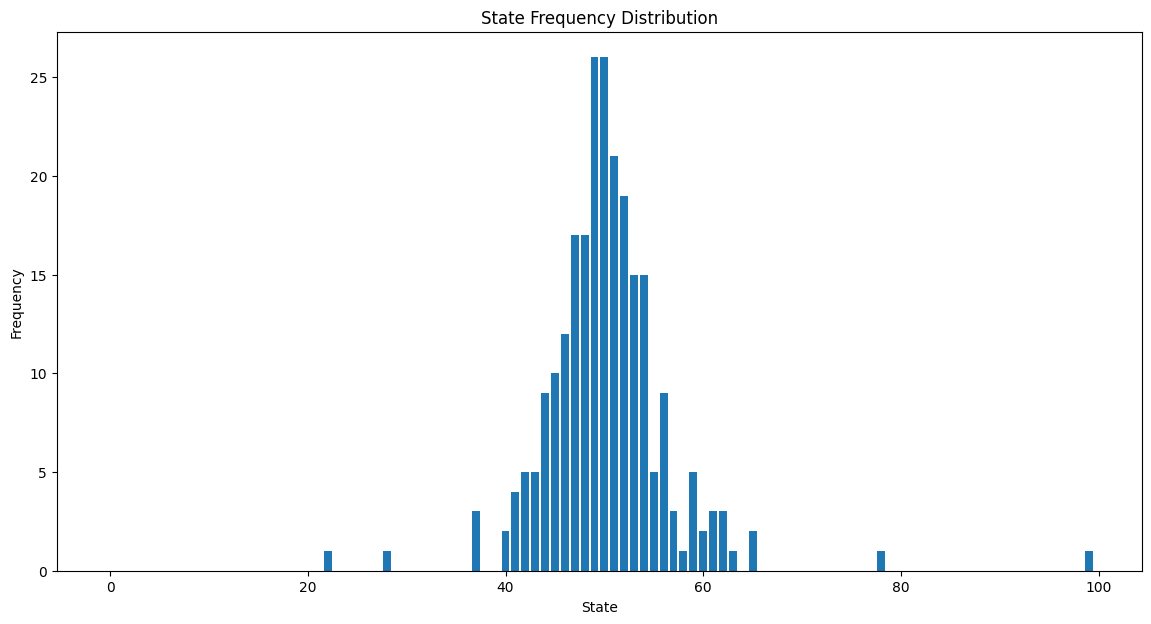

In [6]:
# 改变离散化参数，观察结果变化
main('sh000001', '20000101', '20181231', '20190101', '20191231', N=100, lower_bound=-10, upper_bound=10)